In [2]:
#@title imports 
import os
import pickle
from typing import Set
# from jedi import settings
import matplotlib 
import numpy as np 
import matplotlib.pyplot as plt
from numpy.lib.function_base import append 
import scipy.io as spio
from scipy.io import loadmat, savemat
import importlib.util
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
from scipy.sparse import data 
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
from plotnine.data import mtcars
import pandas as pd 
import matplotlib as mpl 
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import SparsePCA
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
import sys 
sys.path.append('C:/Users/Nishant Joshi/Downloads/Old_code/repo/single_cell_analysis/scripts')

from UMAP import *
# from heatmap import heatmap, corrplot

In [5]:
# features_ext = ['Vm_avg', 'dvdt_p', 'dvdt_n', 'avg_V', 'resistance', 'thr',
#                 'adaptation','isi','peak','peak_adaptation','ap_width', 'hyp_value',
#                 'fist_spike','up_down_ratio', 'isi_adaptation', 'thr_adp_ind', 'psth',
#                 'int_fr','fr', 'sub_thr','mi','spk_fr_adp','imp','cond','exp_name']

features_ext = ['Vm_avg', 'dvdt_p','dvdt_n','avg_V','resistance','thr','adaptation','isi','peak',
                'peak_adaptation','ap_width', 'hyp_value','fist_spike','up_down_ratio','isi_adaptation',
                'thr_adp_ind','psth','int_fr','fr', 'sub_thr','mi','spk_fr_adp','imp','exp_name','cond' ]               
data_all_conds = pickle.load(open('G:/My Drive/Cluster Feature files/all_acsf_ephys_with_MI_new.p','rb'))
exc = data_all_conds['exc']
inh = data_all_conds['inh']
exc_df = pd.DataFrame(exc,columns = features_ext)
exc_df = pd.concat((exc_df.groupby('cond').get_group('aCSF'),
                    exc_df.groupby('cond').get_group('ACSF')))
exc_df = exc_df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
inh_df = pd.DataFrame(inh,columns = features_ext)
inh_df = inh_df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
inh_df = pd.concat((inh_df.groupby('cond').get_group('aCSF'),
                    inh_df.groupby('cond').get_group('ACSF')))


In [40]:
inh_df.to_csv('G:/My Drive/Cluster Feature files/feature_set_inh.csv')

In [6]:
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

def plot_UMAP_clusters(data_inh,data_exc,neighbours,distance,condition_inh,condition_exc,k_exc,k_inh,random_state):
    """plots UMAP for excitatory and inhibitory cells 

    Args:
        data_inh (ndarray): cell X feature matrix for inhibitory cells
        data_exc (ndarray): cell X feature matrix for excitatory cells
        c_exc (array): _description_
        c_inh (array): _description_
        neighbours (int): number of neares neighbours
        distance (float): minimum distance between points
    """
    data_exc_umap_scaler = StandardScaler()
    data_exc_umap = data_exc_umap_scaler.fit_transform(data_exc)
    data_exc_umap = normalize(data_exc_umap)
    data_inh_umap = data_exc_umap_scaler.fit_transform(data_inh)
    data_inh_umap = normalize(data_inh_umap)

    neighbours = neighbours
    dist = distance
    clusterable_embedding2d_exc = umap.UMAP(n_neighbors=neighbours,min_dist=dist,
        n_components=2,random_state=random_state,).fit_transform(data_exc_umap)
    #initialize kmeans parameters
    kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "random_state": 1,
    }

    #create list to hold SSE values for each k
    sse = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(clusterable_embedding2d_exc)
        sse.append(kmeans.inertia_)

    #visualize results
    plt.plot(range(1, 11), sse)
    plt.xticks(range(1, 11))
    plt.xlabel("Number of Clusters exc")
    plt.ylabel("SSE")
    plt.show()

    fig = plt.figure(figsize=[10,4])
    ax12d = fig.add_subplot(1,2,1)

    kmeans_exc = KMeans(n_clusters=k_exc,random_state=random_state).fit(clusterable_embedding2d_exc)
    centroids_exc = kmeans_exc.cluster_centers_
    labels_exc = kmeans_exc.labels_.astype(float)

    df_2d_exc = {'Dim1':clusterable_embedding2d_exc[:, 0],
             'Dim2':clusterable_embedding2d_exc[:, 1],
             'condition':condition_exc,
             'labels':labels_exc}


    sns.scatterplot(data=df_2d_exc,x='Dim1',y='Dim2',hue='labels',  cmap='gist_rainbow',ax=ax12d)
    ax12d.set_title('UMAP clusters for excitatory neurons 2D')
    plt.show()


    clusterable_embedding3d_inh = umap.UMAP(n_neighbors=neighbours, min_dist=dist,
                                        n_components=3,random_state=random_state).fit_transform(data_inh_umap)

    clusterable_embedding2d_inh = umap.UMAP(n_neighbors=neighbours, min_dist=dist,
                                        n_components=2,random_state=random_state).fit_transform(data_inh_umap)

    #initialize kmeans parameters
    kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "random_state": 1,
    }

    #create list to hold SSE values for each k
    sse = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(clusterable_embedding2d_inh)
        sse.append(kmeans.inertia_)

    #visualize results
    plt.plot(range(1, 11), sse)
    plt.xticks(range(1, 11))
    plt.xlabel("Number of Clusters inh")
    plt.ylabel("SSE")
    plt.show()

    fig = plt.figure(figsize=[10,4])
    # ax2 = fig.add_subplot(1,2,1,projection='3d')
    ax22d = fig.add_subplot(1,2,2)
    
    kmeans_inh = KMeans(n_clusters=k_inh,random_state=random_state).fit(clusterable_embedding2d_inh)
    centroids_inh = kmeans_inh.cluster_centers_
    labels_inh = kmeans_inh.labels_.astype(float)

    df_2d_inh = {'Dim1':clusterable_embedding2d_inh[:, 0],
                'Dim2':clusterable_embedding2d_inh[:, 1],
                'condition':condition_inh,
                'labels':labels_inh}


    # sns.scatterplot(data=df_3d,x='Dim1',y='Dim2',hue='condition',  cmap='gist_rainbow',ax=ax22d)

    # ax2.scatter(clusterable_embedding3d[:, 0], clusterable_embedding3d[:, 1], clusterable_embedding3d[:, 2],c=c_inh,  cmap='gist_rainbow')
    # ax2.set_title('UMAP clusters for inhibitory neurons 3D')
    sns.scatterplot(data=df_2d_inh,x='Dim1',y='Dim2',hue='labels',  cmap='gist_rainbow',ax=ax22d)
    ax22d.set_title('UMAP clusters for inhibitory neurons 2D')
    plt.show()
    return labels_exc, labels_inh

def plot_UMAP(data_inh,data_exc,neighbours,distance,condition_inh,condition_exc,figsize=None,random_state=0):
    """plots UMAP for excitatory and inhibitory cells 

    Args:
        data_inh (ndarray): cell X feature matrix for inhibitory cells
        data_exc (ndarray): cell X feature matrix for excitatory cells
        c_exc (array): _description_
        c_inh (array): _description_
        neighbours (int): number of neares neighbours
        distance (float): minimum distance between points
    """
    data_exc_umap_scaler = StandardScaler()
    data_exc_umap = data_exc_umap_scaler.fit_transform(data_exc)
    data_exc_umap = normalize(data_exc_umap)
    data_inh_umap = data_exc_umap_scaler.fit_transform(data_inh)
    data_inh_umap = normalize(data_inh_umap)
    fig = plt.figure(figsize=figsize)
    ax12d = fig.add_subplot(1,2,1)
    neighbours = neighbours
    dist = distance
    clusterable_embedding2d = umap.UMAP(n_neighbors=neighbours,min_dist=dist,
        n_components=2,random_state=random_state,).fit_transform(data_exc_umap)
    df_2d = {'Dim1':clusterable_embedding2d[:, 0],
             'Dim2':clusterable_embedding2d[:, 1],
             'condition':condition_exc}
    sns.scatterplot(data=df_2d,x='Dim1',y='Dim2',hue='condition',  cmap='gist_rainbow',ax=ax12d)
    ax12d.set_title('UMAP excitatory')
    ax22d = fig.add_subplot(1,2,2)
    clusterable_embedding2d = umap.UMAP(n_neighbors=neighbours, min_dist=dist,
                                        n_components=2,random_state=random_state).fit_transform(data_inh_umap)
    df_2d = {'Dim1':clusterable_embedding2d[:, 0],
             'Dim2':clusterable_embedding2d[:, 1],
             'condition':condition_inh}
    sns.scatterplot(data=df_2d,x='Dim1',y='Dim2',hue='condition',  cmap='gist_rainbow',ax=ax22d)
    ax22d.set_title('UMAP inhibitory')


    plt.show()

def plot_UMAP_combined(data_exc,data_inh,neighbours,distance,random_state,figsize):

    data_scaler = StandardScaler()
    data_all = np.concatenate((data_exc,data_inh))
    data_all = data_scaler.fit_transform(data_all)
    data_all = normalize(data_all)
    fig = plt.figure(figsize=figsize,dpi=200)
    # ax1 = fig.add_subplot(1,2,1,projection='3d')
    ax12d = fig.add_subplot(1,1,1)
    neighbours = neighbours
    dist = distance
    labels = np.concatenate((np.repeat('exc',len(data_exc)),np.repeat('inh',len(data_inh))))
    clusterable_embedding2d = umap.UMAP(n_neighbors=neighbours,min_dist=dist,
        n_components=2,random_state=random_state,).fit_transform(data_all)
    df_2d = pd.DataFrame({'UMAP1':clusterable_embedding2d[:, 0],
             'UMAP2':clusterable_embedding2d[:, 1],
             'type':labels})
    sns.scatterplot(data=df_2d,x='UMAP1',y='UMAP2', hue='type', cmap='gist_rainbow',ax=ax12d,alpha=.5,markers=['x','.'])
    ax12d.set_title('UMAP excitatory and Inhibitory')
    
    plt.show()  

def plot_UMAP_all_conds(data,labels,neighbours,distance,random_state,figsize):

    data_scaler = StandardScaler()
    data = data_scaler.fit_transform(data)
    data = normalize(data)
    fig = plt.figure(figsize=figsize)
    ax12d = fig.add_subplot(1,1,1)
    neighbours = neighbours
    dist = distance
    labels = labels
    clusterable_embedding2d = umap.UMAP(n_neighbors=neighbours,min_dist=dist,
        n_components=2,random_state=random_state,).fit_transform(data)
    df_2d = pd.DataFrame({'Dim1':clusterable_embedding2d[:, 0],
             'Dim2':clusterable_embedding2d[:, 1],
             'type':labels})
    sns.scatterplot(data=df_2d,x='Dim1',y='Dim2', hue='type', cmap='gist_rainbow',ax=ax12d,alpha=.5,markers=['x','.'])
    ax12d.set_title('UMAP all conditions')
  
    plt.show()      

def plot_UMAP_clusters_hbd(data_inh,data_exc,neighbours,distance,min_samples,min_cluster_size,random_state):
    """plots UMAP for excitatory and inhibitory cells 

    Args:
        data_inh (ndarray): cell X feature matrix for inhibitory cells
        data_exc (ndarray): cell X feature matrix for excitatory cells
        c_exc (array): _description_
        c_inh (array): _description_
        neighbours (int): number of neares neighbours
        distance (float): minimum distance between points
    """
    data_exc_umap_scaler = StandardScaler()
    data_exc_umap = data_exc_umap_scaler.fit_transform(data_exc)
    data_exc_umap = normalize(data_exc_umap)
    data_inh_umap = data_exc_umap_scaler.fit_transform(data_inh)
    data_inh_umap = normalize(data_inh_umap)

    fig = plt.figure(figsize=[10,4])
    ax12d = fig.add_subplot(1,2,1)
    neighbours = neighbours
    dist = distance

    clusterable_embedding2d_exc = umap.UMAP(n_neighbors=neighbours,min_dist=dist,
        n_components=2,random_state=random_state,).fit_transform(data_exc_umap)



    labels_exc = hdbscan.HDBSCAN(
        min_samples=min_samples,
        min_cluster_size=min_cluster_size,
    ).fit_predict(data_exc_umap)


    df_2d_exc = {'Dim1':clusterable_embedding2d_exc[:, 0],
             'Dim2':clusterable_embedding2d_exc[:, 1],
             'labels':labels_exc}


    sns.scatterplot(data=df_2d_exc,x='Dim1',y='Dim2',hue='labels',  cmap='gist_rainbow',ax=ax12d)
    ax12d.set_title('UMAP clusters for excitatory neurons 2D')
    plt.show()

    fig = plt.figure(figsize=[10,4])
    ax22d = fig.add_subplot(1,2,2)
    
    clusterable_embedding2d_inh = umap.UMAP(n_neighbors=neighbours, min_dist=dist,
                                        n_components=2,random_state=random_state).fit_transform(data_inh_umap)

    labels_inh = hdbscan.HDBSCAN(
        min_samples=min_samples,
        min_cluster_size=min_cluster_size,
    ).fit_predict(data_inh_umap)

    df_2d_inh = {'Dim1':clusterable_embedding2d_inh[:, 0],
                'Dim2':clusterable_embedding2d_inh[:, 1],
                'labels':labels_inh}

    sns.scatterplot(data=df_2d_inh,x='Dim1',y='Dim2',hue='labels',  cmap='gist_rainbow',ax=ax22d)
    ax22d.set_title('UMAP clusters for inhibitory neurons 2D')

    plt.show()
    return labels_exc, labels_inh


5


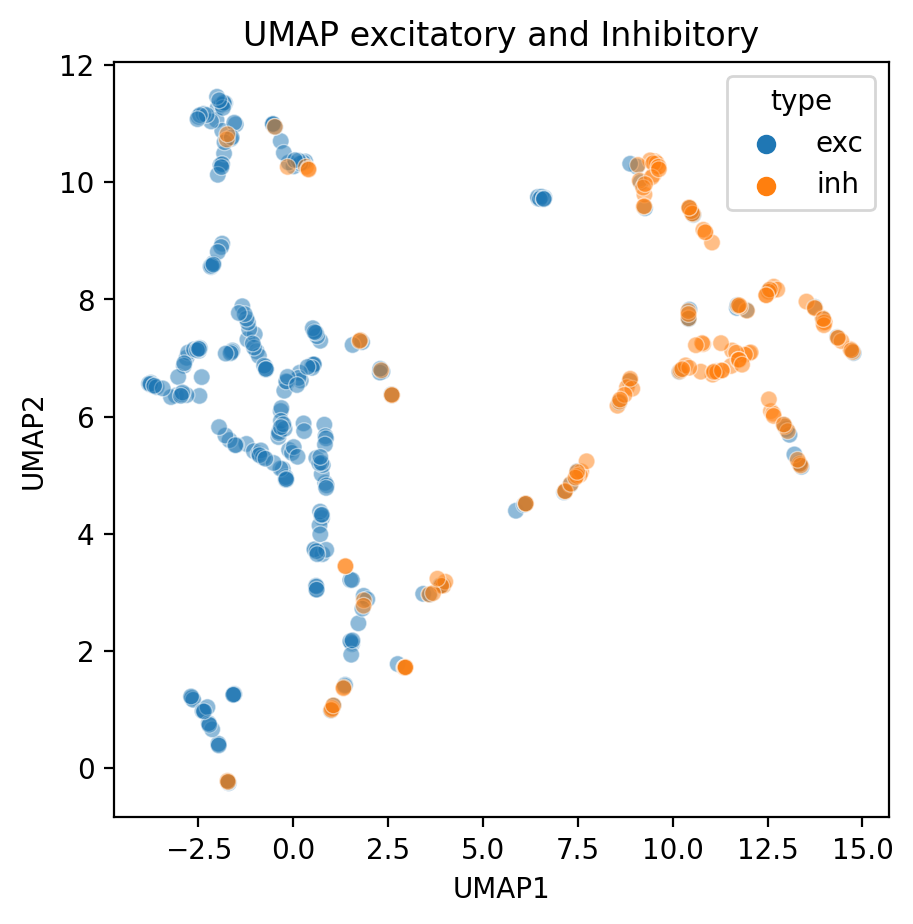

10


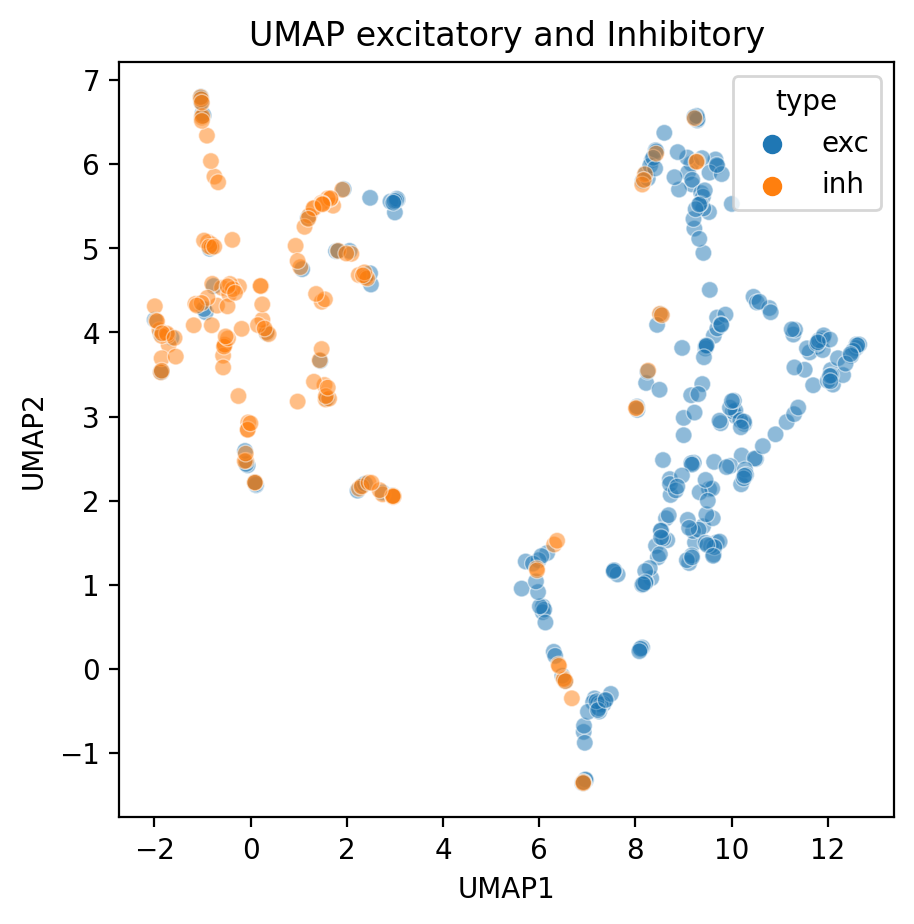

15


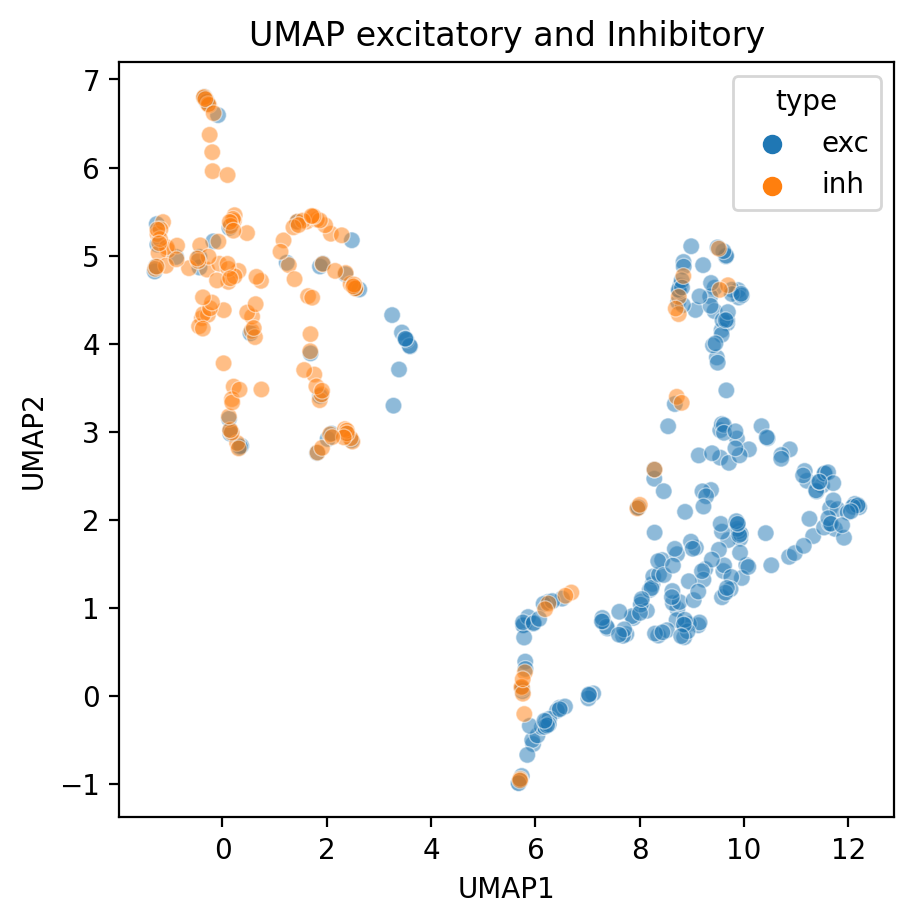

20


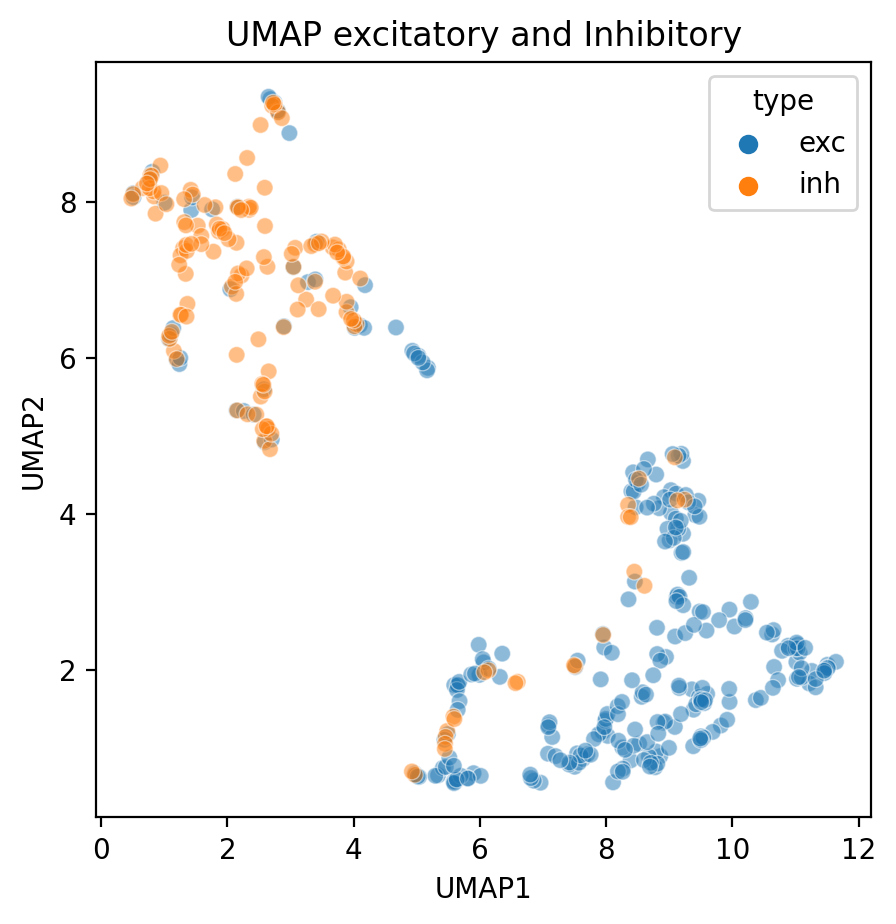

25


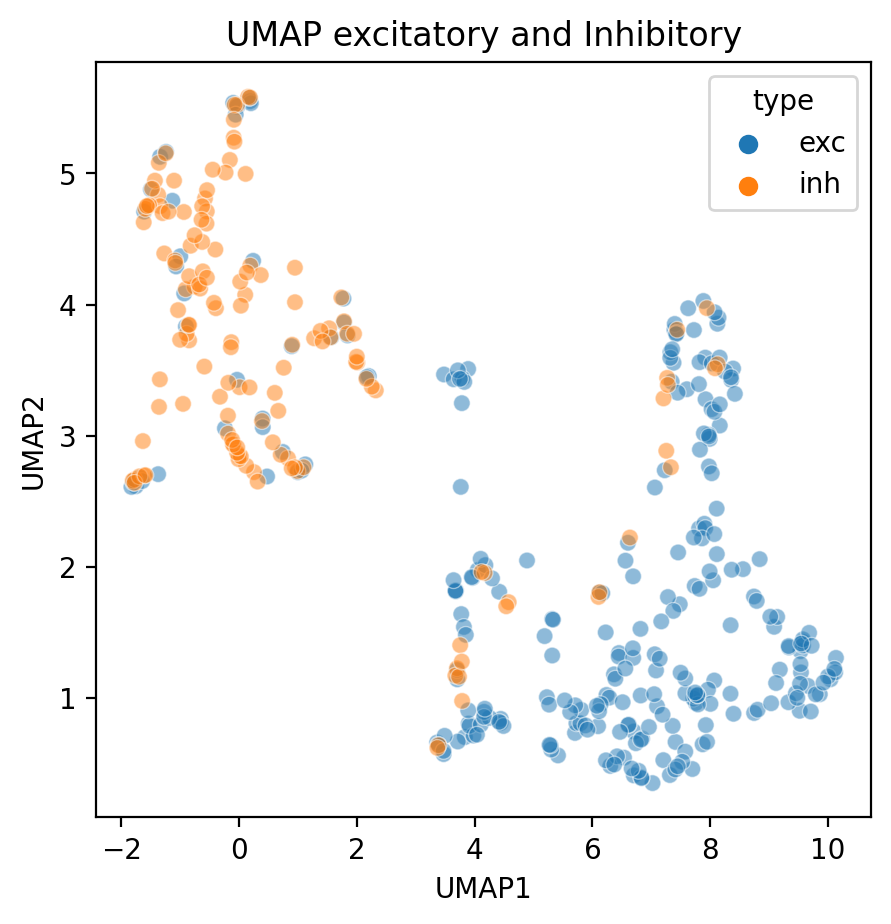

30


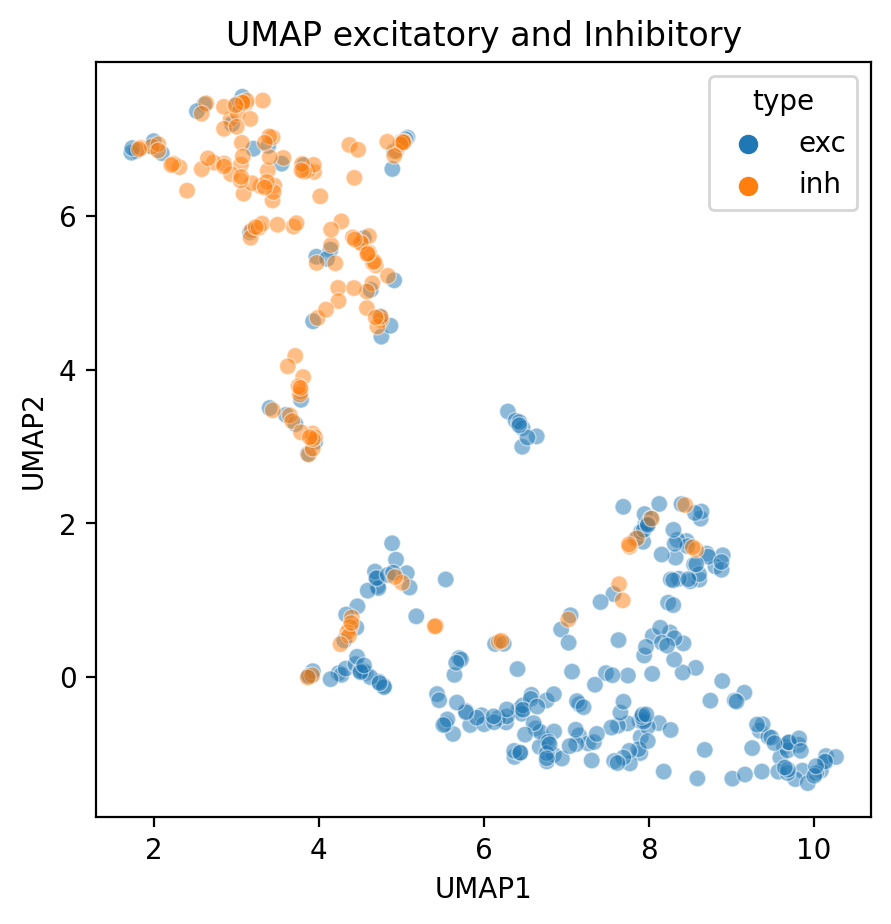

35


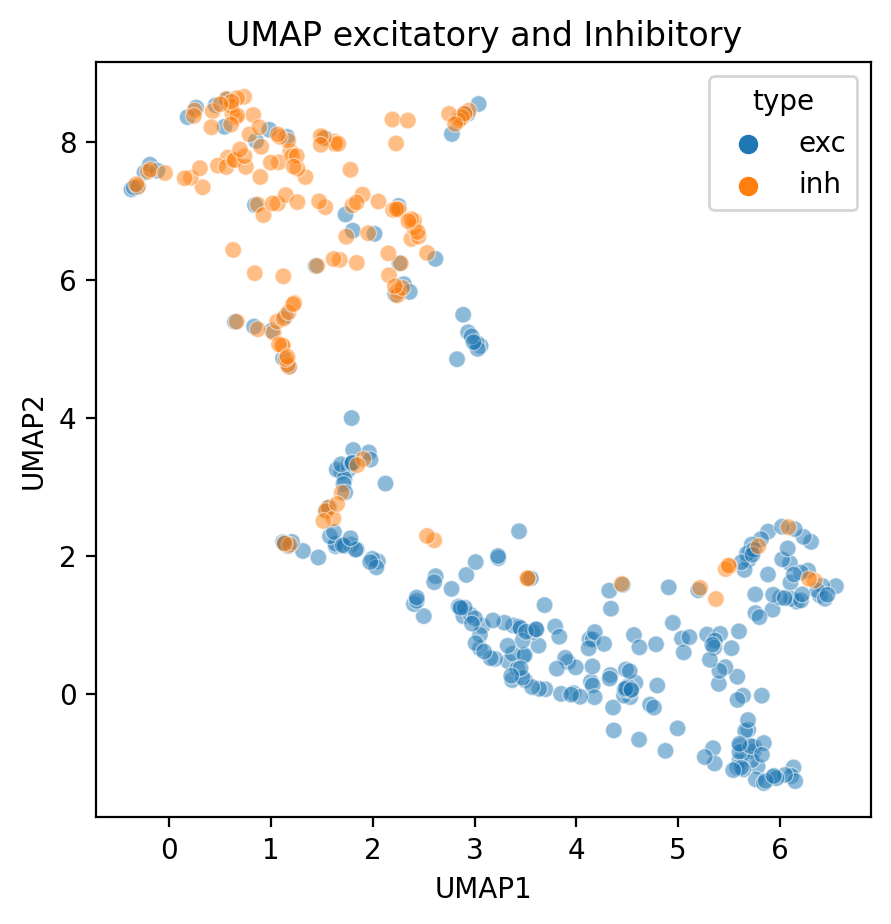

40


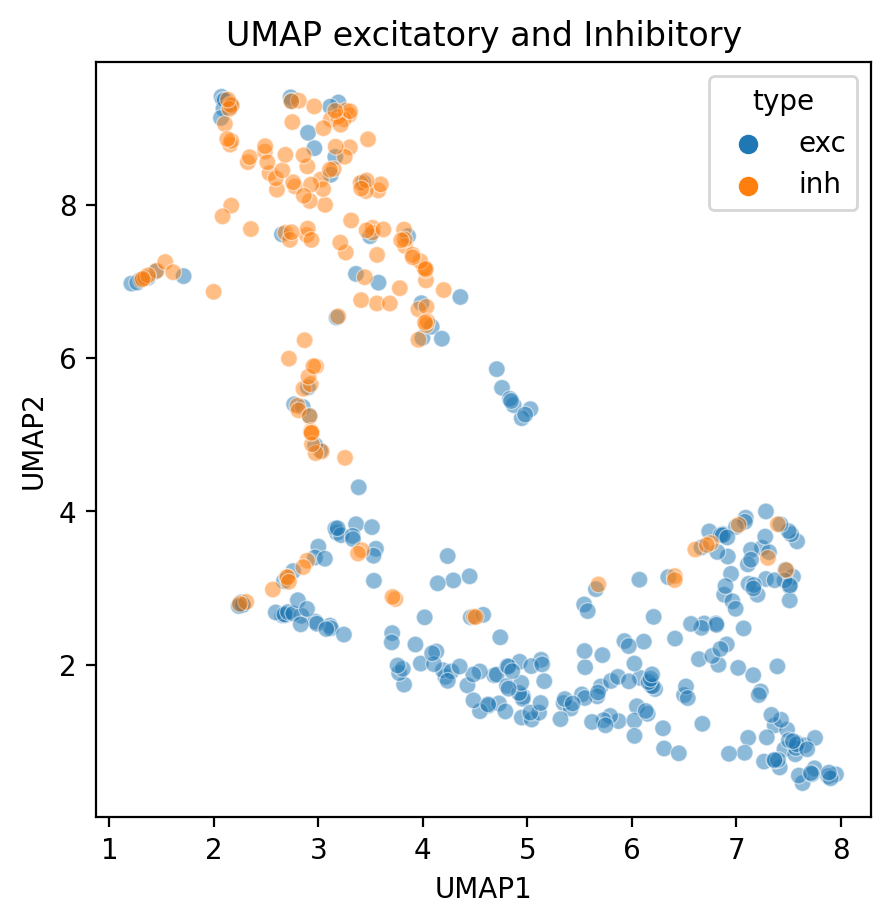

45


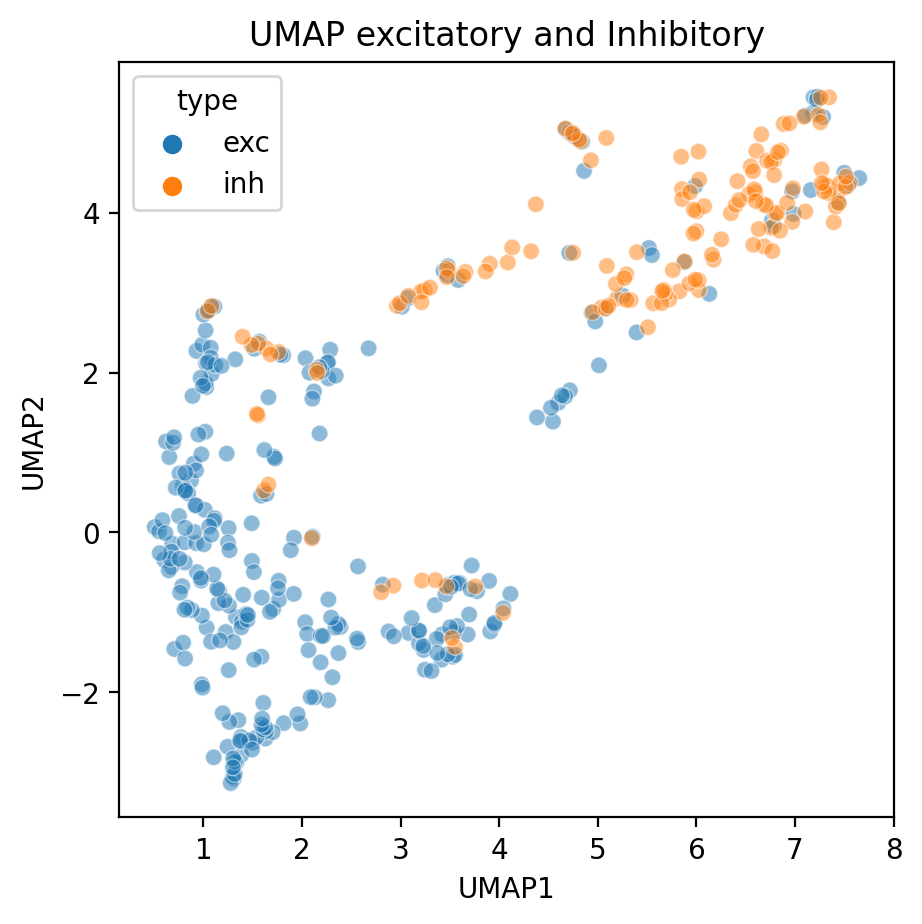

In [494]:
df_exc = exc_df#df_all_conds_exc 
df_inh = inh_df#df_all_conds_inh 

df_exc['labels'] = np.repeat('exc',len(df_exc))
df_inh['labels'] = np.repeat('inh',len(df_inh))
df_comb = pd.concat((df_exc,df_inh))

for i in range(5,50,5):
    print(i)
    plot_UMAP_combined(df_exc[['Vm_avg', 'resistance', 'thr', 'isi', 'sub_thr', 'imp']],
                       df_inh[['Vm_avg', 'resistance', 'thr', 'isi', 'sub_thr', 'imp']],
                       i,0.0,1,[5,5])

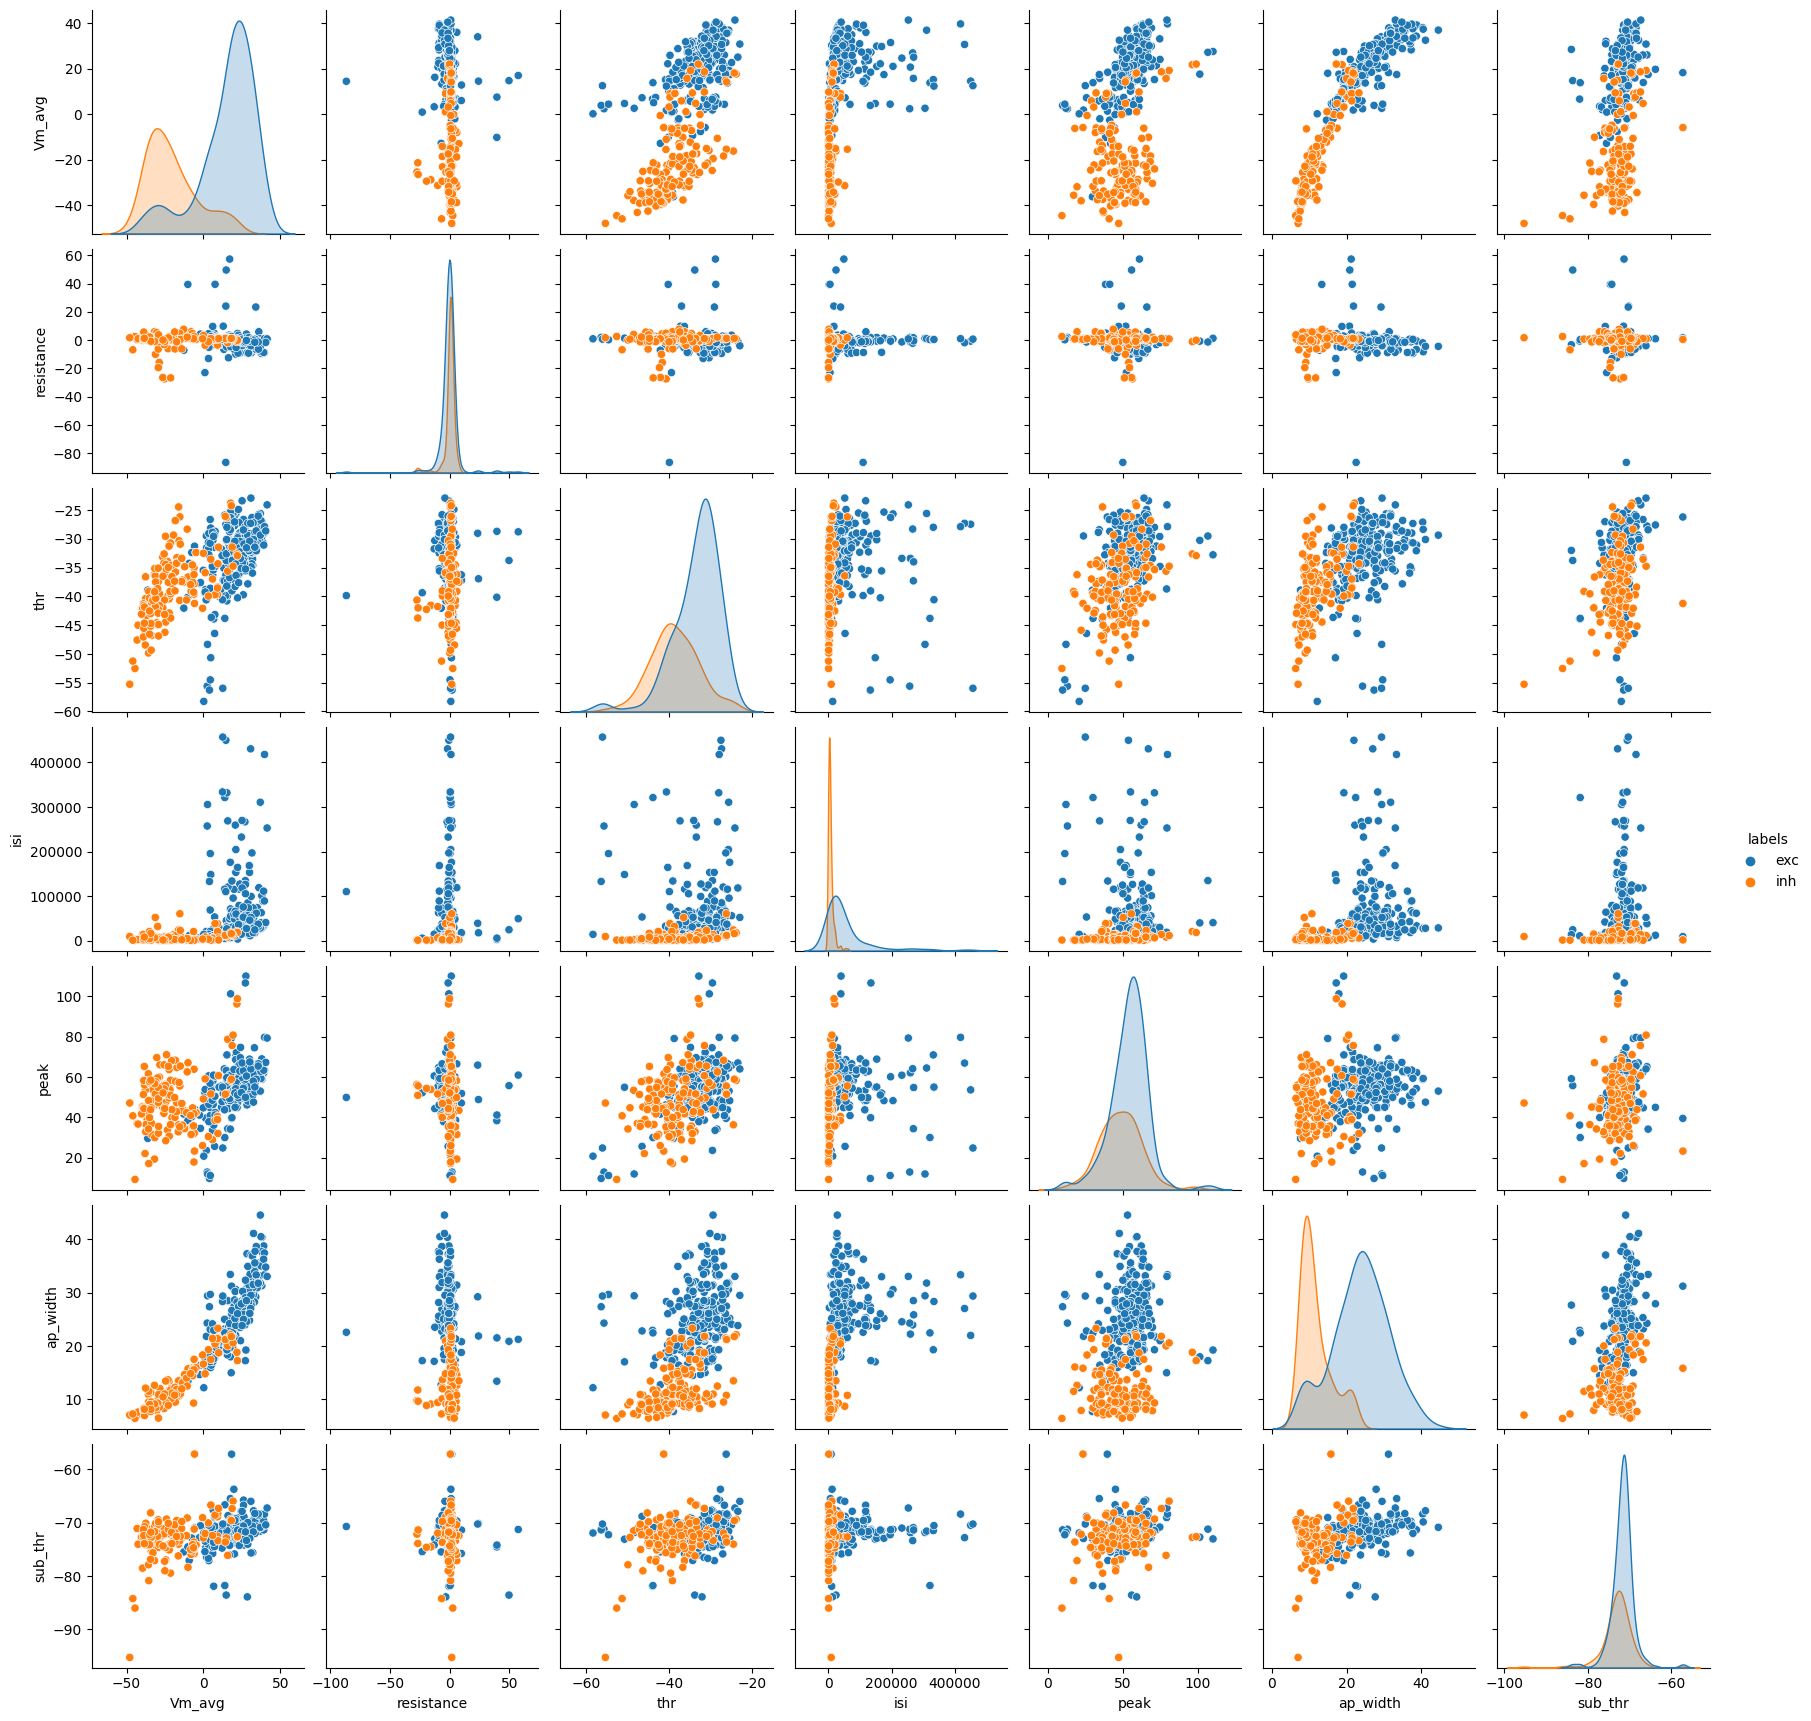

In [ ]:
sns.pairplot(df_comb[['Vm_avg', 'resistance', 'thr', 'isi', 'peak', 'ap_width',  'sub_thr','labels']],hue='labels')

In [ ]:
plt.scatter(x=np.arange(len(df_exc)),y=df_exc['thr'],data=df_exc)
plt.scatter(np.arange(len(df_inh['thr'])),df_inh['thr'])
plt.ylabel('Thresholds')
plt.title('excitatory v inhibitory')
plt.show()
plt.scatter(np.arange(len(df_exc['Vm_avg'])),df_exc['Vm_avg'])
plt.scatter(np.arange(len(df_inh['Vm_avg'])),df_inh['Vm_avg'])
plt.ylabel('Vm_avg')
plt.title('excitatory v inhibitory')

plt.show()
plt.scatter(df_exc['Vm_avg'],df_exc['thr'])
plt.scatter(df_inh['Vm_avg'],df_inh['thr'])
plt.xlabel('Vm_avg')
plt.ylabel('thresholds')
plt.title('excitatory v inhibitory')
plt.show()


5 0.0


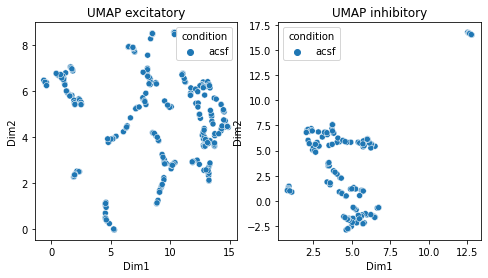

10 0.0


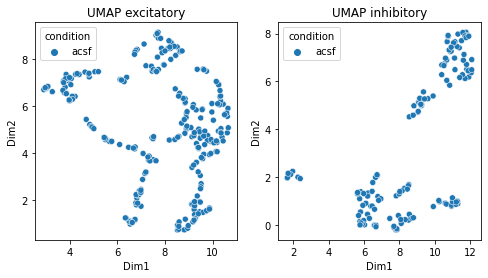

15 0.0


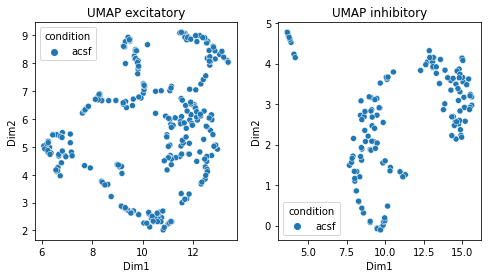

20 0.0


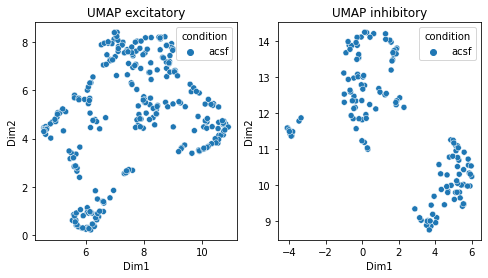

25 0.0


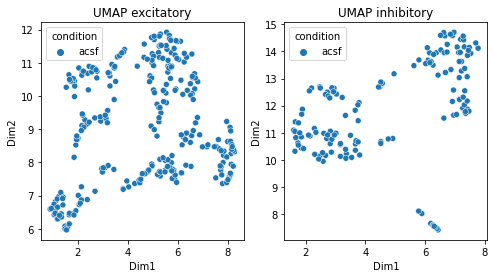

30 0.0


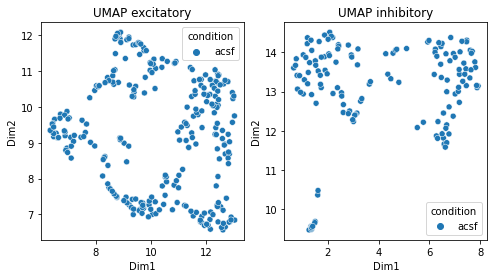

35 0.0


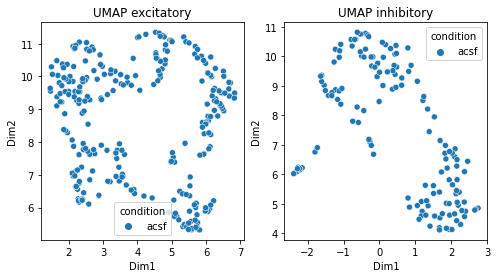

In [12]:
#@title create UMAP embeddings
feat = ['Vm_avg', 'resistance', 'thr', 'isi', 'sub_thr', 'imp']

df_exc = exc_df #pd.DataFrame(data_exc,columns=features)
df_inh = inh_df #pd.DataFrame(data_inh,columns=features)

neighbours  = np.arange(5,40,5)
# distances = np.arange(0.05,0.5,0.05)
distances = [0.0]
for n in neighbours:
    for dist in distances:
        print(n, dist)
        plot_UMAP(df_inh[['Vm_avg', 'resistance', 'thr', 'isi', 'sub_thr','imp']],
                  df_exc[['Vm_avg', 'resistance', 'thr', 'isi', 'sub_thr','imp']],
                  n,
                  dist,
                  np.repeat(['acsf'],len(df_inh)),np.repeat(['acsf'],len(df_exc)),
                  figsize=[8,4],
                  random_state=42)
                #   'blue','blue',n,dist,labels_inh,labels_exc,figsize=[8,4],random_state=65)


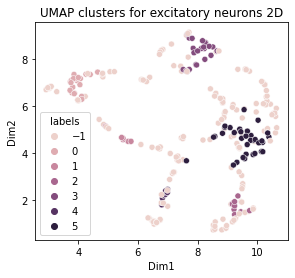

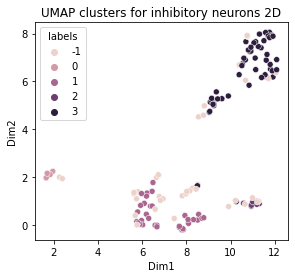

In [30]:
#@title clustering the UMAP embeddings

df_exc = exc_df
df_inh = inh_df
ind_feat = ['Vm_avg', 'resistance', 'thr', 'isi', 'sub_thr','imp']
lab_exc,lab_inh = plot_UMAP_clusters_hbd(df_inh[ind_feat],df_exc[ind_feat],10,0.0,5,5,42)

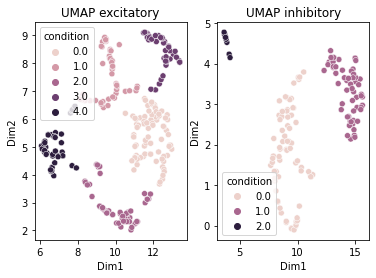

In [31]:
#@title clustering the UMAP embeddings

df_exc_NC = exc_df[['Vm_avg', 'resistance', 'thr', 'isi', 'sub_thr','imp']] # df_all_conds_exc[['Vm_avg', 'resistance', 'thr', 'isi', 'sub_thr','thr']] #pd.DataFrame(data_exc,columns=features)
df_inh_NC = inh_df[['Vm_avg', 'resistance', 'thr', 'isi', 'sub_thr','imp']]       #df_all_conds_inh[['Vm_avg', 'resistance', 'thr', 'isi', 'sub_thr','thr']] #pd.DataFrame(data_inh,columns=features)

plot_UMAP(df_inh_NC,
          df_exc_NC,
          15,
          0.0,
          condition_inh=labels_inh,
          condition_exc=labels_exc,
          random_state=42)


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.


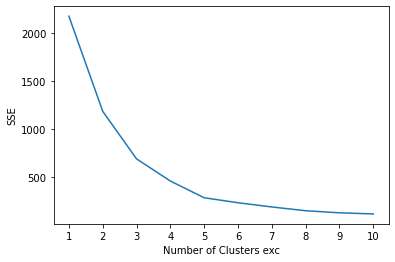

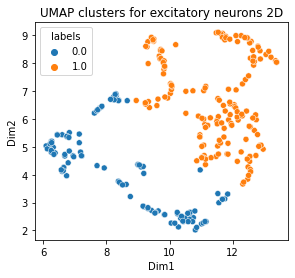

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.


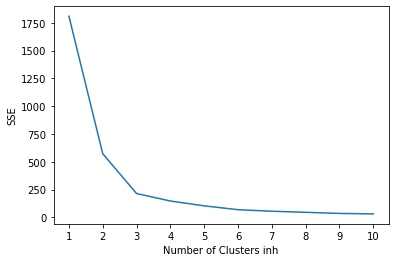

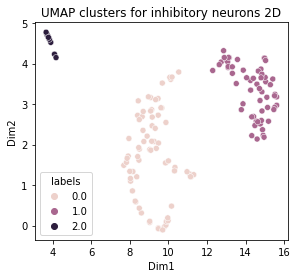

In [32]:
#@title clustering the UMAP embeddings

df_exc_NC = exc_df[['Vm_avg', 'resistance', 'thr', 'isi', 'sub_thr','imp']] # df_all_conds_exc[['Vm_avg', 'resistance', 'thr', 'isi', 'sub_thr','thr']] #pd.DataFrame(data_exc,columns=features)
df_inh_NC = inh_df[['Vm_avg', 'resistance', 'thr', 'isi', 'sub_thr','imp']]       #df_all_conds_inh[['Vm_avg', 'resistance', 'thr', 'isi', 'sub_thr','thr']] #pd.DataFrame(data_inh,columns=features)
ind_feat = [0,3,4,6,18,20]


labels_exc, labels_inh = plot_UMAP_clusters(df_inh_NC,
                                       df_exc_NC,
                                       15,
                                       0.0,
                                       condition_inh=np.repeat(['acsf'],len(df_inh_NC)),
                                       condition_exc=np.repeat(['acsf'],len(df_exc_NC)),
                                       k_inh=3,
                                       k_exc=2,
                                       random_state=42)



In [249]:
#@title effect of noise
fac = 0.1
# data_exc = exc_df #data_acsf_exc_all_conds
# data_inh = inh_df #data_acsf_inh_all_conds

# df_exc_NC = pd.DataFrame(data_exc,columns=features)
# df_inh_NC = pd.DataFrame(data_inh,columns=features)

# data_exc_w_noise =data_exc +fac*np.random.randn(data_exc.shape[0],data_exc.shape[1])
# data_inh_w_noise =data_inh +fac*np.random.randn(data_inh.shape[0],data_inh.shape[1])

df_exc_NC = exc_df #pd.DataFrame(data_exc,columns=features)
df_inh_NC = inh_df #pd.DataFrame(data_inh,columns=features)

df_exc_NC_w_noise = exc_df # pd.DataFrame(data_exc_w_noise,columns=features)
df_inh_NC_w_noise = inh_df # pd.DataFrame(data_inh_w_noise,columns=features)


plot_UMAP(df_inh_NC,
            df_exc_NC,
            'blue','blue',15,0.0,labels_inh,labels_exc,figsize=[8,4],random_state=42)


plot_UMAP(df_inh_NC_w_noise[df_inh_NC_w_noise.columns[ind_feat]],
          df_exc_NC_w_noise[df_exc_NC_w_noise.columns[ind_feat]],
            'blue','blue',15,0.0,labels_inh,labels_exc,figsize=[8,4],random_state=42)

ValueError: could not convert string to float: 'NC_170711_aCSF_D1ago_E1'

In [ ]:
#@title effect of seed
df_exc_NC = pd.DataFrame(data_exc,columns=features)
df_inh_NC = pd.DataFrame(data_inh,columns=features)


plot_UMAP(df_inh_NC[df_inh_NC.columns[ind_feat]],
            df_exc_NC[df_exc_NC.columns[ind_feat]],
            'blue','blue',15,0.0,labels_inh,labels_exc,figsize=[8,4],random_state=42)

plot_UMAP(df_inh_NC[df_inh_NC.columns[ind_feat]],
            df_exc_NC[df_exc_NC.columns[ind_feat]],
            'blue','blue',15,0.0,labels_inh,labels_exc,figsize=[8,4],random_state=300)


ValueError: ignored

/usr/local/lib/python3.9/dist-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/usr/local/lib/python3.9/dist-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


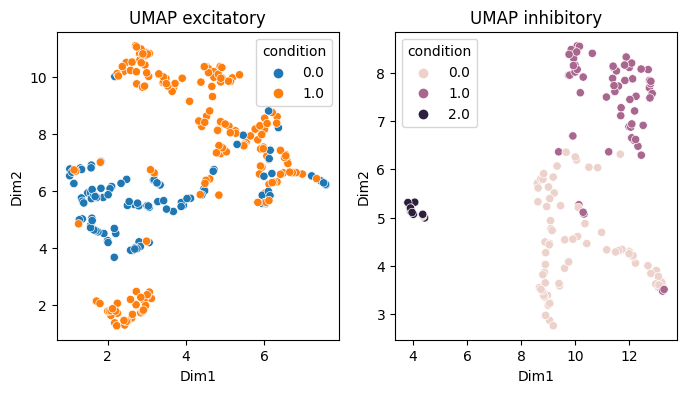

/usr/local/lib/python3.9/dist-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/usr/local/lib/python3.9/dist-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


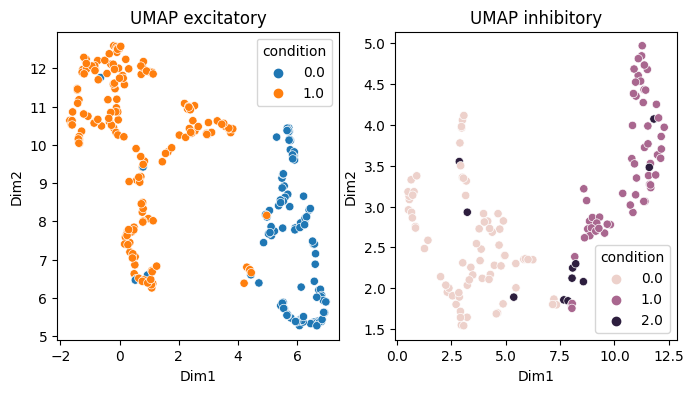

/usr/local/lib/python3.9/dist-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/usr/local/lib/python3.9/dist-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


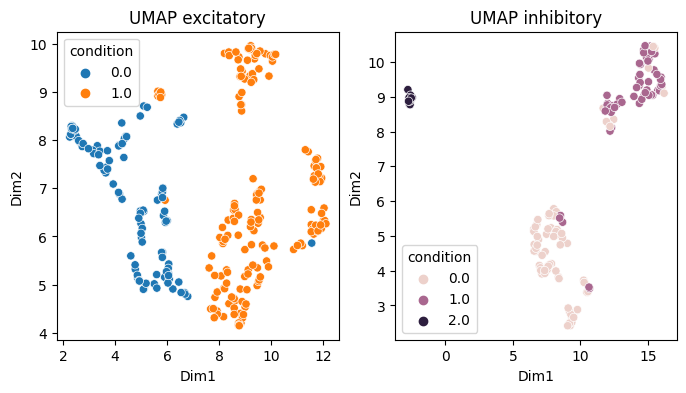

/usr/local/lib/python3.9/dist-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/usr/local/lib/python3.9/dist-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


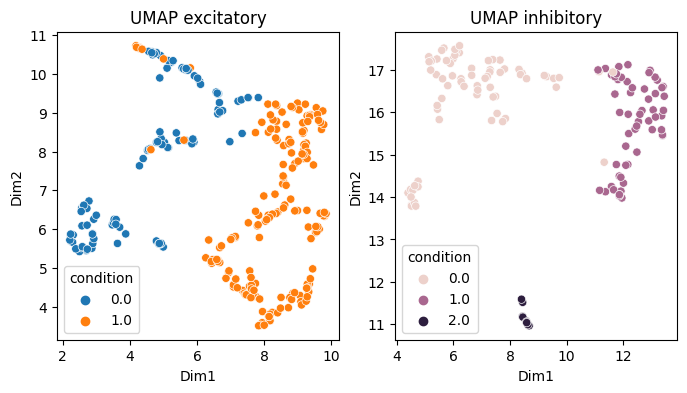

/usr/local/lib/python3.9/dist-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/usr/local/lib/python3.9/dist-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


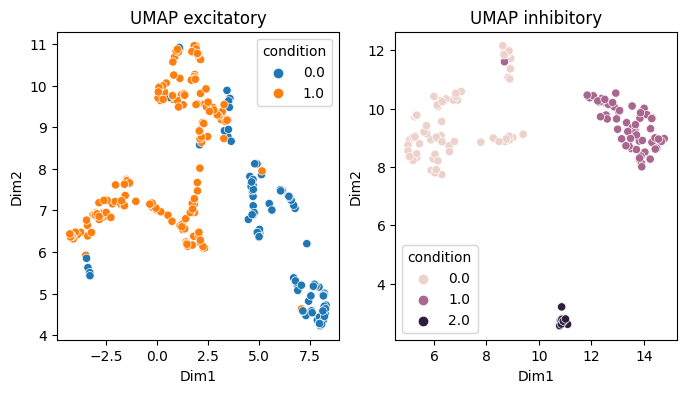

/usr/local/lib/python3.9/dist-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/usr/local/lib/python3.9/dist-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


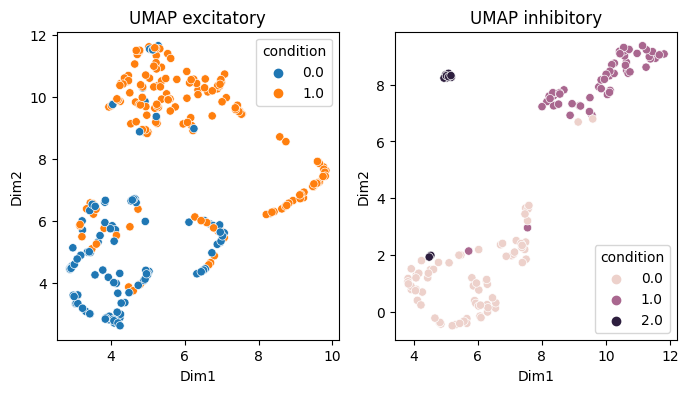

In [ ]:
for i in range(len(ind_feat)):
    inds = np.ones_like(ind_feat,dtype=bool)
    inds[i] = False
    plot_UMAP(df_inh_NC[df_inh_NC.columns[ind_feat][inds]],
            df_exc_NC[df_exc_NC.columns[ind_feat][inds]],
            'blue','blue',15,0.0,labels_inh,labels_exc,figsize=[8,4],random_state=200)
    

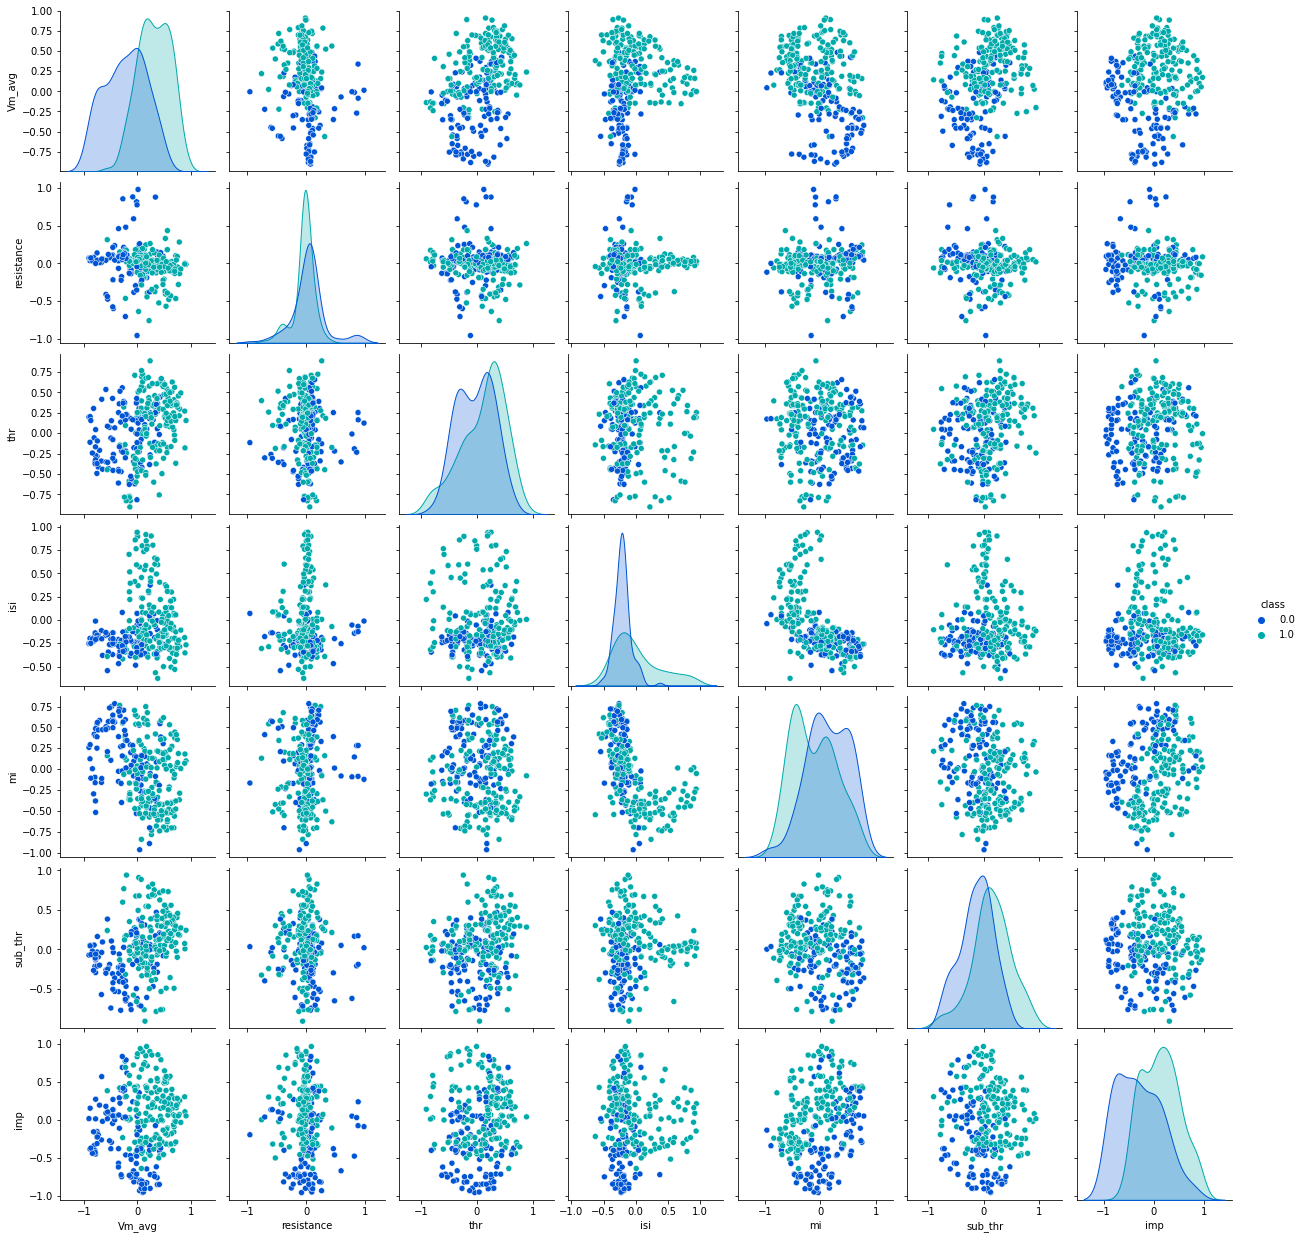

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# transform data
feat = ['Vm_avg', 'resistance', 'thr','mi', 'isi', 'sub_thr','imp']
df_exc = exc_df[['Vm_avg', 'resistance', 'thr', 'isi','mi', 'sub_thr','imp','exp_name']].reset_index(drop=True)
df = scaler.fit_transform(df_exc[feat])
df = normalize(df)
df_exc[feat] = df
df_exc['class'] = labels_exc

sns.pairplot(df_exc,
            hue='class',
            diag_kws = {'common_norm':False,
                        'common_grid':True,},
                        palette='winter')
plt.show()

<ipython-input-44-a20c971c040f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-44-a20c971c040f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

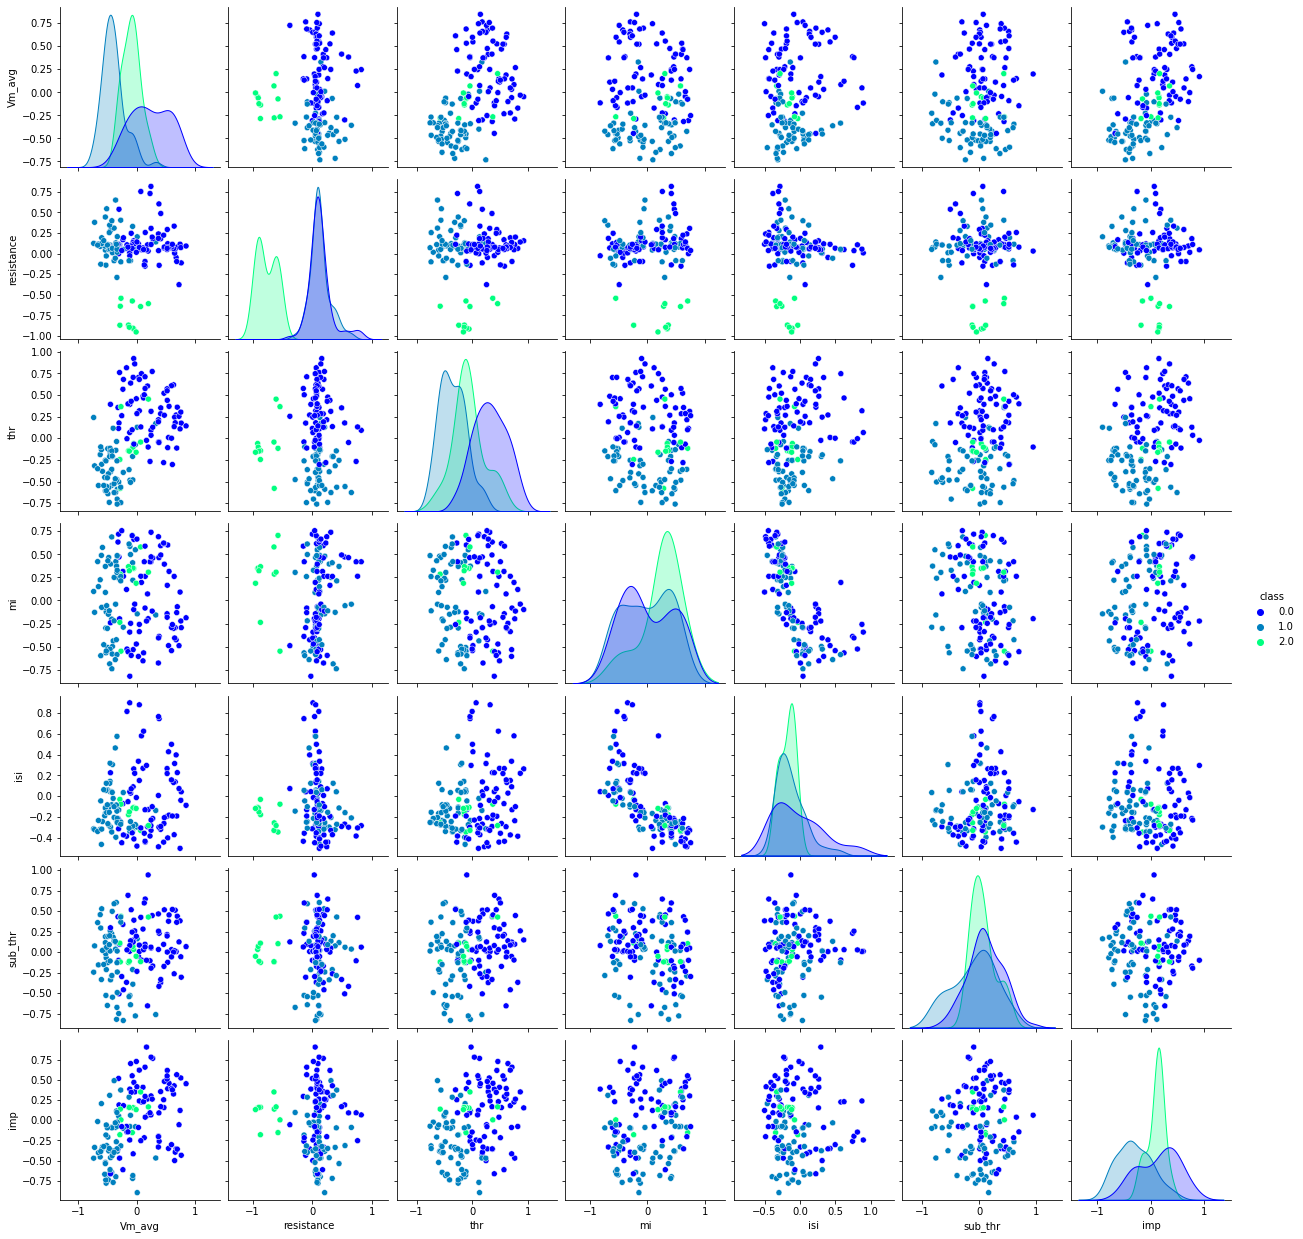

In [44]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# transform data
feat = ['Vm_avg', 'resistance', 'thr','mi', 'isi', 'sub_thr','imp']
df_inh = inh_df[['Vm_avg', 'resistance', 'thr','mi', 'isi', 'sub_thr','imp','exp_name']]
df = scaler.fit_transform(df_inh[feat])
df = normalize(df)
df_inh[feat] = df
df_inh['class'] = labels_inh

sns.pairplot(df_inh[['Vm_avg', 'resistance', 'thr','mi', 'isi', 'sub_thr','imp','class']],
                        hue='class',
                        diag_kws = {'common_norm':False,
                                    'common_grid':True,}
                        ,palette='winter')
plt.show()

In [26]:
from statannotations.Annotator import Annotator


In [27]:
from itertools import combinations


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:6.252e-24 U_stat=2.585e+03
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:4.245e-04 U_stat=1.145e+04
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:3.628e-04 U_stat=6.833e+03
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitne

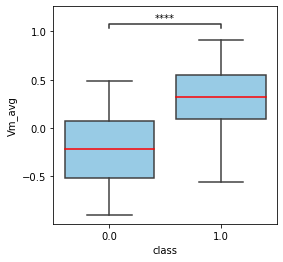

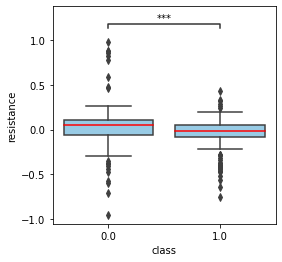

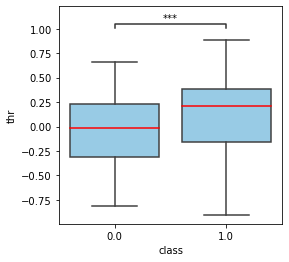

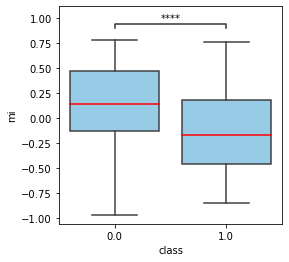

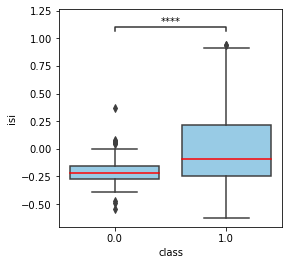

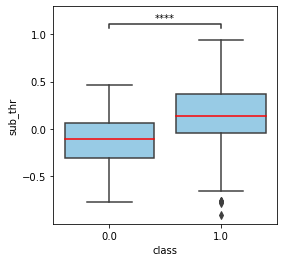

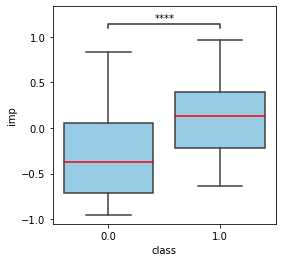

In [34]:
from statannotations.Annotator import Annotator

def plot_significance(data,var,hue):
    fig = plt.figure(figsize=[4,4])
    ax =fig.add_subplot()
    sns.boxplot(data=data,
                x=hue,
                y=var,
                boxprops={"facecolor": (.2, .6, .8, .5)},
                medianprops={"color": "red"},ax=ax)                            

    pairs = np.unique(data[hue])
    pairs = [i for i in combinations(np.arange(0.,len(pairs)),2)]


    annotator = Annotator(ax,pairs, data=data, x=hue, y=var)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='inside')
    annotator.apply_and_annotate()  

ind_feat = [0,3,4,6,9,17,20]
for i in df_exc[['Vm_avg', 'resistance', 'thr','mi', 'isi', 'sub_thr','imp']]:
    plot_significance(df_exc,i,'class')


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:2.823e-19 U_stat=4.115e+03
1.0 vs. 2.0: Mann-Whitney-Wilcoxon test two-sided, P_val:2.194e-05 U_stat=6.100e+01
0.0 vs. 2.0: Mann-Whitney-Wilcoxon test two-sided, P_val:1.918e-03 U_stat=6.360e+02
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:8.083e-01 U_stat=2.100e+03
1.0 vs. 2.0: Mann-Whitney-Wilcoxon test two-sided, P_val:1.708e-07 U_stat=6.490e+02
0.0 vs. 2.0: Mann-Whitney-Wilcoxon test two-sided, P_val:1.055e-07 U_stat=8.030e+02
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.0

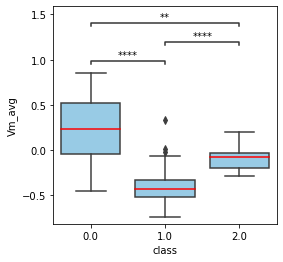

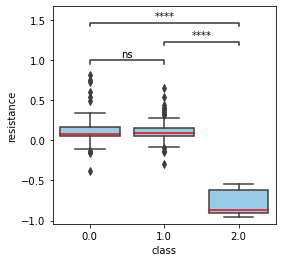

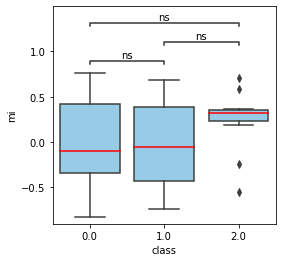

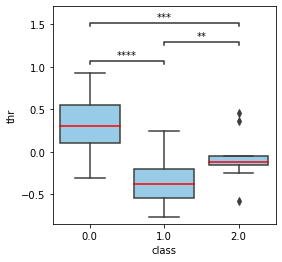

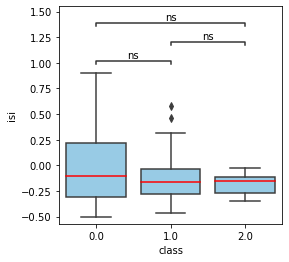

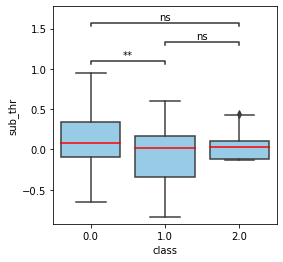

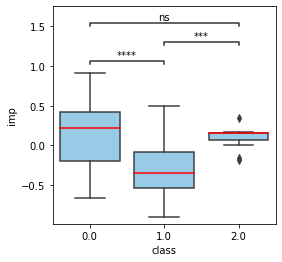

In [31]:
for i in df_inh[['Vm_avg', 'resistance','mi', 'thr', 'isi', 'sub_thr','imp']]:
    plot_significance(df_inh,i,'class')

In [170]:
def modify_cond_list(cond):
    if cond in ['aCSF','ACSF']:
        return  cond.lower()
    elif cond.lower() in ['d1','d1ago']:
        return 'd1ago'
    elif cond.lower() in ['dop','dopamine','dopa']:
        return 'dopamine'
    elif cond.lower() in ['m1-ag', 'm1-ago', 'm1-ago+ant', 'm1-ant', 'm1-ant+ago']:
        return 'm1'
    else:
        return cond.lower()        
def plot_significance_new(data,var,hue,ax,test ='Mann-Whitney'):

    sns.boxplot(data=data,
                x=hue,
                y=var,
                boxprops={"facecolor": (.2, .6, .8, .5)},
                medianprops={"color": "red"},ax=ax)                            

    pairs = np.unique(data[hue])
    pairs = [i for i in combinations(pairs,2)]


    annotator = Annotator(ax,pairs, data=data, x=hue, y=var)
    annotator.configure(test=test, text_format='star', loc='inside')
    annotator.apply_and_annotate()  

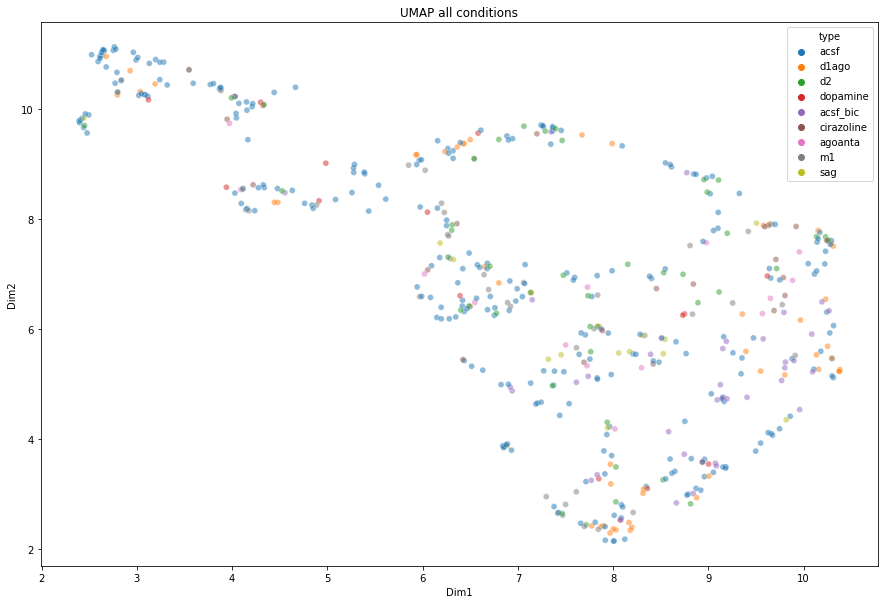

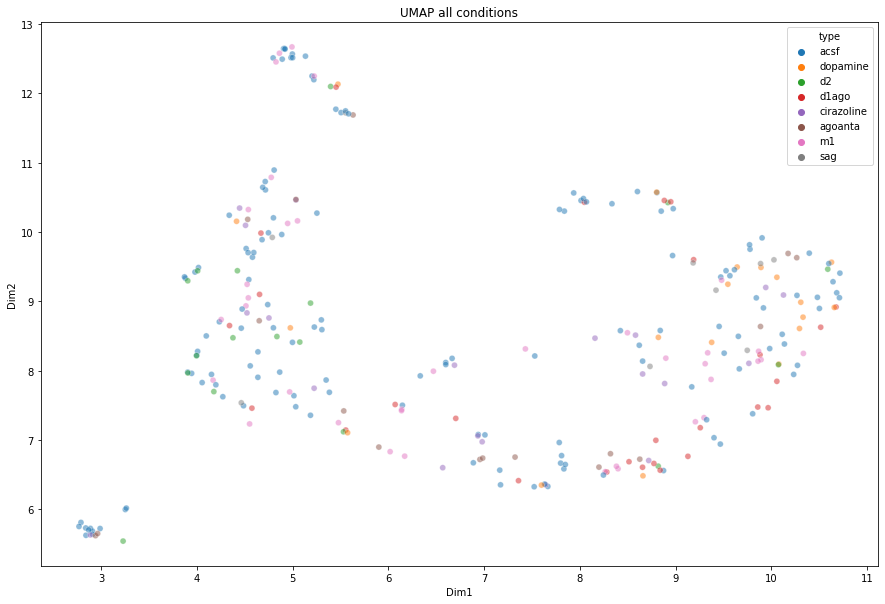

In [104]:
exc = data_all_conds['exc']
inh = data_all_conds['inh']
exc_df_all = pd.DataFrame(exc,columns = features_ext)
exc_df_all = exc_df_all.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
exc_df_all = exc_df_all.reset_index(drop=False)
exc_df_all.cond = exc_df_all.cond.apply(modify_cond_list)
inh_df_all = pd.DataFrame(inh,columns = features_ext)
inh_df_all = inh_df_all.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
inh_df_all = inh_df_all.reset_index(drop=False)
inh_df_all.cond = inh_df_all.cond.apply(modify_cond_list)

plot_UMAP_all_conds(exc_df_all[['Vm_avg', 'resistance', 'thr', 'isi', 'sub_thr','imp']],labels=exc_df_all['cond'],neighbours=20,distance=0.0,random_state=0,figsize=[15,10])
plot_UMAP_all_conds(inh_df_all[['Vm_avg', 'resistance', 'thr', 'isi', 'sub_thr','imp']],labels=inh_df_all['cond'],neighbours=20,distance=0.0,random_state=0,figsize=[15,10])


In [105]:
exc_df_all_ = exc_df_all[exc_df_all.columns[1:]]
inh_df_all_ = inh_df_all[inh_df_all.columns[1:]]


In [117]:
def return_class_based_df(df_acsf,df_all):
    all_dfs = []
    for i in np.unique(df_acsf['class']):
        exp_class_0 = np.unique(df_acsf[df_acsf['class']==i]['exp_name'])
        df_ = df_all[df_all.exp_name.isin(exp_class_0)]
        df_['class'] = i
        all_dfs.append(df_)
    all_dfs_ = pd.concat(all_dfs)
    return all_dfs_,np.unique(all_dfs_.cond)

df_exc_for_sig,conds_exc = return_class_based_df(df_exc, exc_df_all_)
df_inh_for_sig,conds_inh = return_class_based_df(df_inh, inh_df_all_)

<ipython-input-117-a48ebfeff971>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-117-a48ebfeff971>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-117-a48ebfeff971>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-117-a48ebfeff

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: t-test independent samples, P_val:8.711e-20 t=1.067e+01
1.0 vs. 2.0: t-test independent samples, P_val:7.402e-05 t=-4.198e+00
0.0 vs. 2.0: t-test independent samples, P_val:2.968e-03 t=3.057e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: t-test independent samples, P_val:5.339e-01 t=6.237e-01
1.0 vs. 2.0: t-test independent samples, P_val:1.740e-15 t=1.006e+01
0.0 vs. 2.0: t-test independent samples, P_val:1.179e-18 t=1.125e+01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: t-test independent samples, P

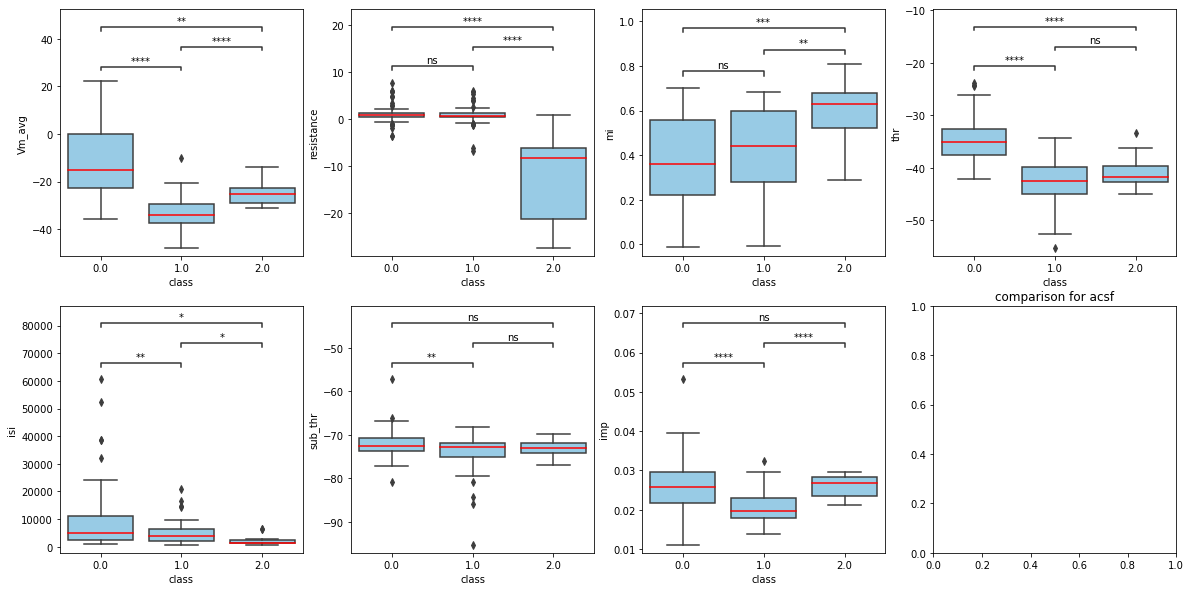

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: t-test independent samples, P_val:1.926e-02 t=2.844e+00
1.0 vs. 2.0: t-test independent samples, P_val:2.404e-02 t=-2.709e+00
0.0 vs. 2.0: t-test independent samples, P_val:8.521e-01 t=1.947e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: t-test independent samples, P_val:8.693e-01 t=-1.693e-01
1.0 vs. 2.0: t-test independent samples, P_val:7.125e-02 t=2.044e+00
0.0 vs. 2.0: t-test independent samples, P_val:1.553e-01 t=1.625e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: t-test independent samples, 

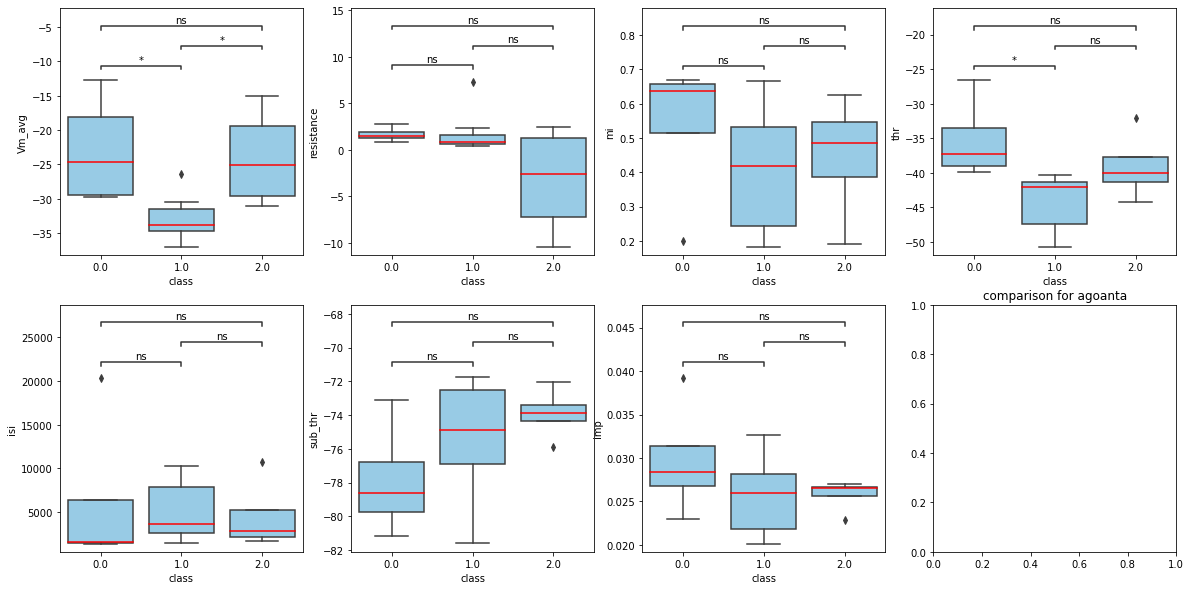

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: t-test independent samples, P_val:4.307e-03 t=3.509e+00
1.0 vs. 2.0: t-test independent samples, P_val:9.945e-03 t=-3.253e+00
0.0 vs. 2.0: t-test independent samples, P_val:5.418e-01 t=6.411e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: t-test independent samples, P_val:6.067e-01 t=5.286e-01
1.0 vs. 2.0: t-test independent samples, P_val:7.112e-02 t=2.046e+00
0.0 vs. 2.0: t-test independent samples, P_val:3.099e-02 t=2.692e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: t-test independent samples, P

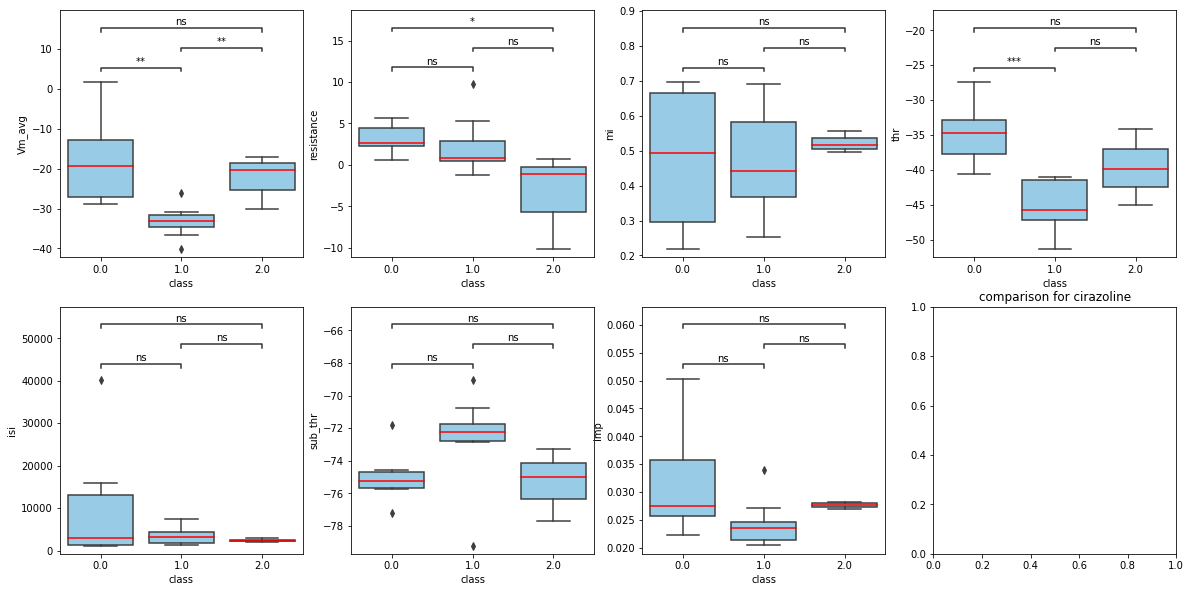

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: t-test independent samples, P_val:4.866e-02 t=2.077e+00
1.0 vs. 2.0: t-test independent samples, P_val:3.004e-01 t=-1.063e+00
0.0 vs. 2.0: t-test independent samples, P_val:7.890e-01 t=2.799e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: t-test independent samples, P_val:9.665e-01 t=4.248e-02
1.0 vs. 2.0: t-test independent samples, P_val:8.334e-01 t=-2.131e-01
0.0 vs. 2.0: t-test independent samples, P_val:2.049e-01 t=-1.422e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: t-test independent samples,

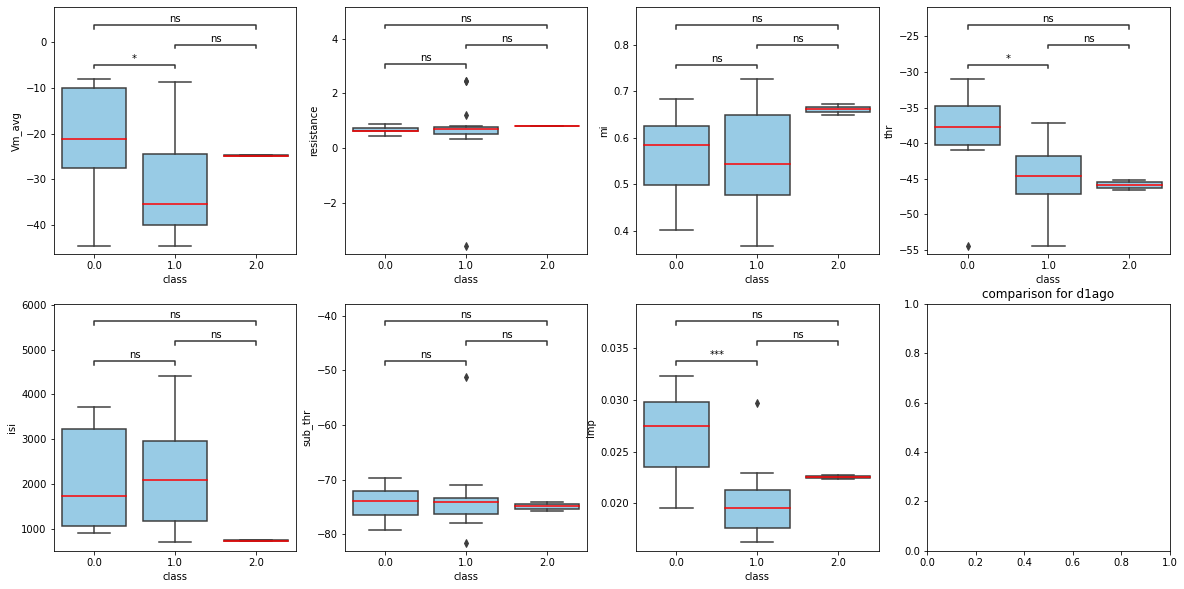

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: t-test independent samples, P_val:9.467e-04 t=4.250e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: t-test independent samples, P_val:6.030e-03 t=3.275e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: t-test independent samples, P_val:5.862e-01 t=5.581e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: t-test independent samples, P_val:7.395e-03 t=3.169e+00


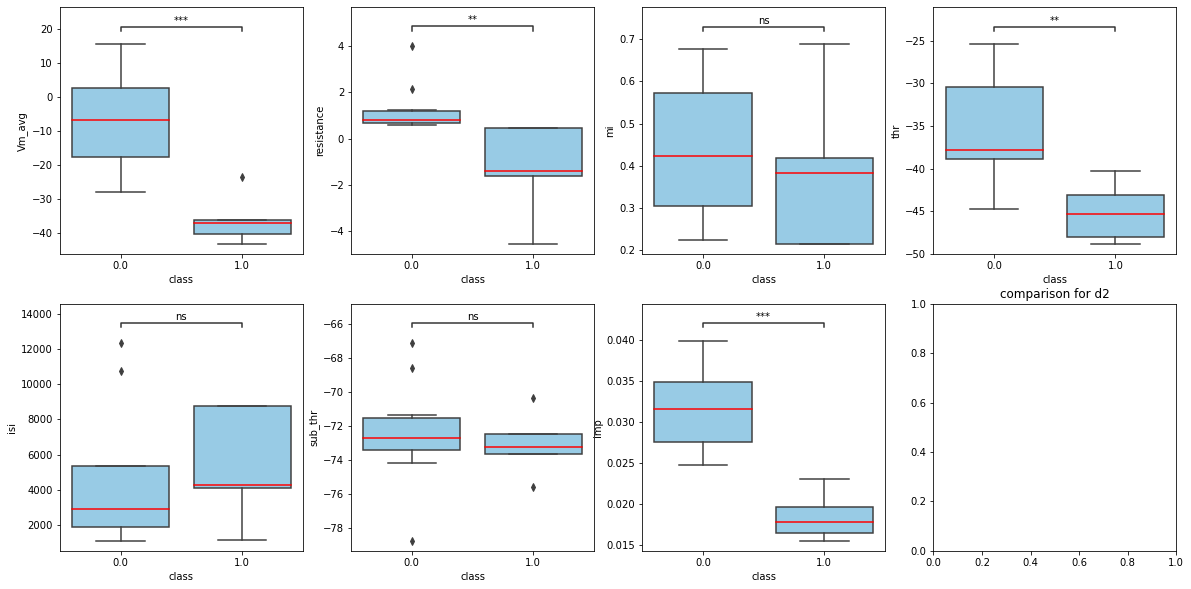

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: t-test independent samples, P_val:7.639e-03 t=3.113e+00
1.0 vs. 2.0: t-test independent samples, P_val:nan t=nan
0.0 vs. 2.0: t-test independent samples, P_val:nan t=nan


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: t-test independent samples, P_val:7.677e-01 t=3.012e-01
1.0 vs. 2.0: t-test independent samples, P_val:nan t=nan
0.0 vs. 2.0: t-test independent samples, P_val:nan t=nan
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: t-test independent samples, P_val:8.835e-01 t=-1.492e-01


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


1.0 vs. 2.0: t-test independent samples, P_val:nan t=nan
0.0 vs. 2.0: t-test independent samples, P_val:nan t=nan


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: t-test independent samples, P_val:3.194e-02 t=2.382e+00
1.0 vs. 2.0: t-test independent samples, P_val:nan t=nan
0.0 vs. 2.0: t-test independent samples, P_val:nan t=nan
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: t-test independent samples, P_val:9.162e-02 t=1.811e+00


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


1.0 vs. 2.0: t-test independent samples, P_val:nan t=nan
0.0 vs. 2.0: t-test independent samples, P_val:nan t=nan


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: t-test independent samples, P_val:9.044e-01 t=-1.223e-01
1.0 vs. 2.0: t-test independent samples, P_val:nan t=nan
0.0 vs. 2.0: t-test independent samples, P_val:nan t=nan


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: t-test independent samples, P_val:2.993e-02 t=2.416e+00
1.0 vs. 2.0: t-test independent samples, P_val:nan t=nan
0.0 vs. 2.0: t-test independent samples, P_val:nan t=nan


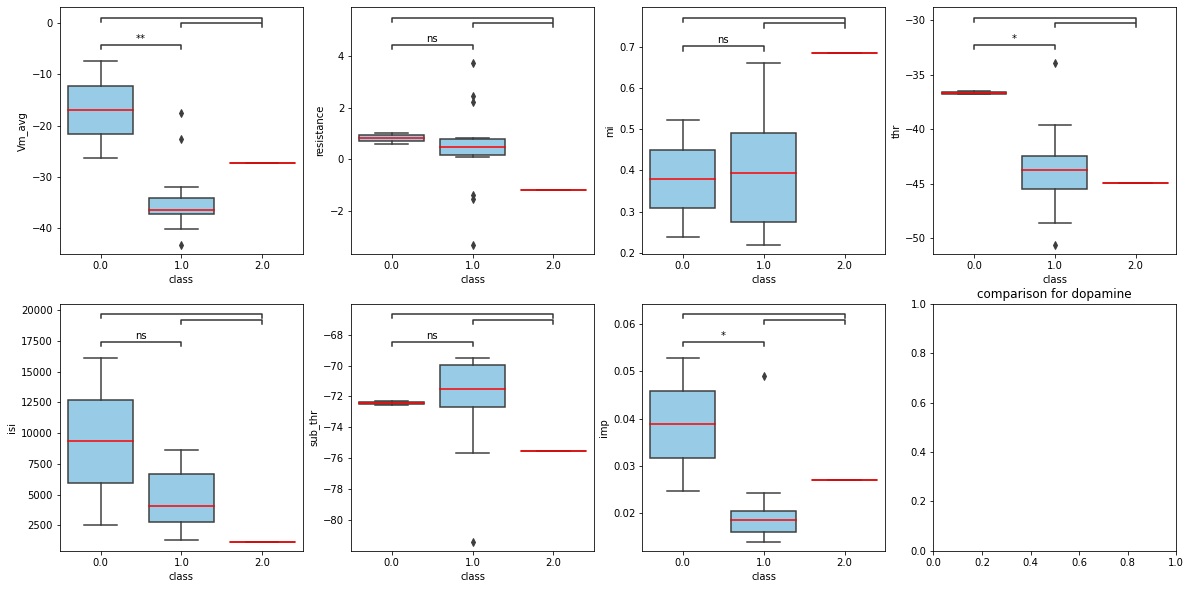

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: t-test independent samples, P_val:2.096e-11 t=1.003e+01
1.0 vs. 2.0: t-test independent samples, P_val:2.932e-02 t=-2.427e+00
0.0 vs. 2.0: t-test independent samples, P_val:3.230e-02 t=2.301e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: t-test independent samples, P_val:5.749e-01 t=5.666e-01
1.0 vs. 2.0: t-test independent samples, P_val:1.338e-02 t=-2.830e+00
0.0 vs. 2.0: t-test independent samples, P_val:7.808e-03 t=-2.956e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: t-test independent samples,

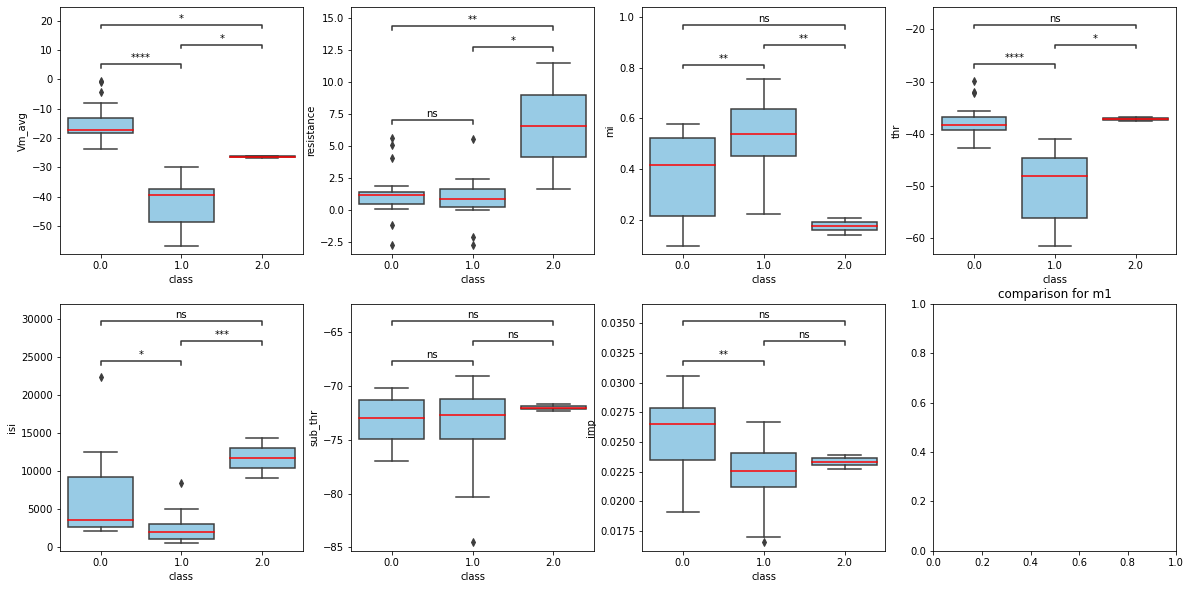

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: t-test independent samples, P_val:5.115e-02 t=2.349e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: t-test independent samples, P_val:8.281e-01 t=2.254e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: t-test independent samples, P_val:6.471e-01 t=-4.782e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: t-test independent samples, P_val:1.236e-02 t=3.344e+00

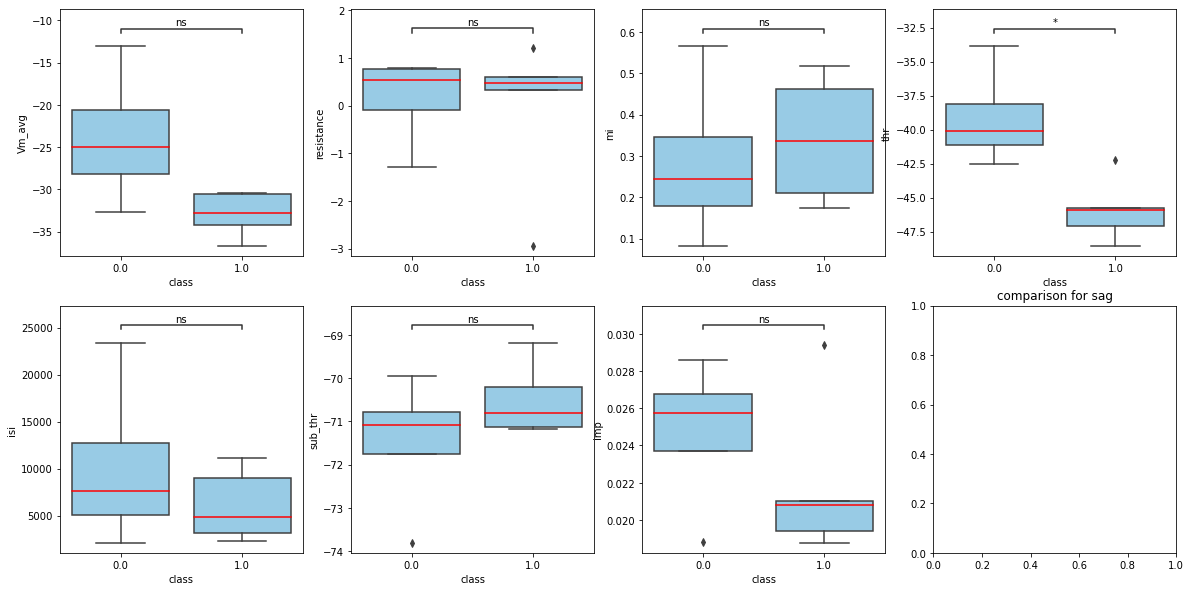

In [172]:

for cond_i in conds_inh:
    fig,ax = plt.subplots(2,4,figsize=[20,10])
    for i,val in enumerate(['Vm_avg', 'resistance','mi', 'thr', 'isi', 'sub_thr','imp']):
        if i<4:
            plot_significance_new(data = df_inh_for_sig[df_inh_for_sig.cond==cond_i],var = val,hue = 'class',ax = ax[0,i],test='t-test_ind')
        else:
            plot_significance_new(data = df_inh_for_sig[df_inh_for_sig.cond==cond_i],var = val,hue = 'class',ax = ax[1,i-4],test='t-test_ind')
    plt.title('comparison for '+cond_i)
    plt.show()


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:3.368e-23 U_stat=3.754e+03
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:1.861e-03 U_stat=1.369e+04
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:5.394e-05 U_stat=1.439e+04
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitne

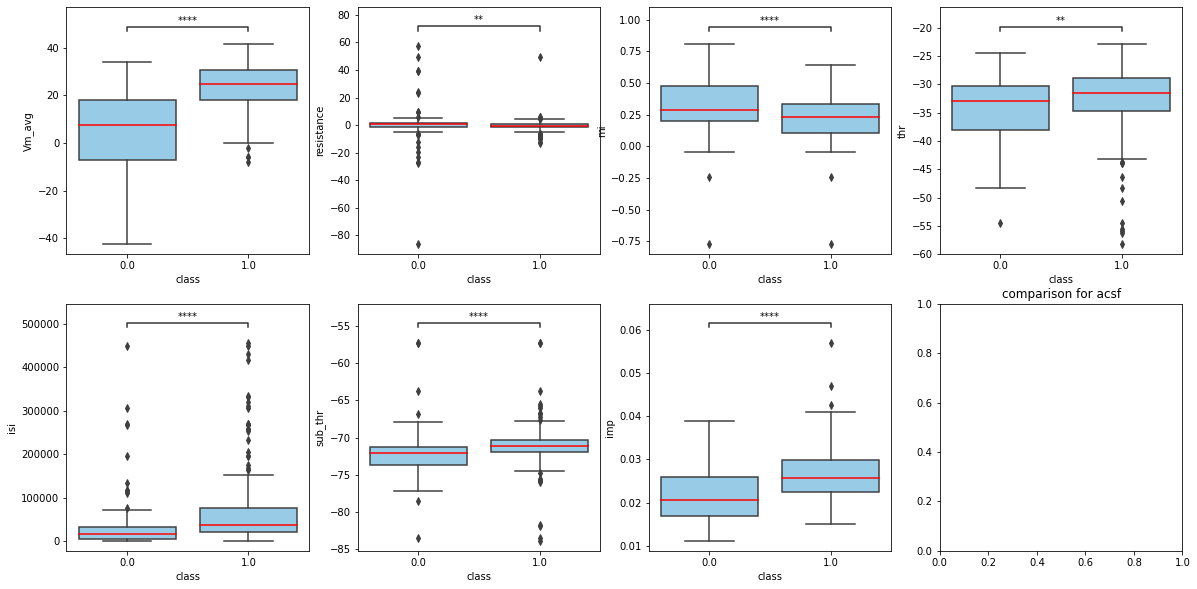

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:5.523e-02 U_stat=1.000e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:7.842e-01 U_stat=1.400e+01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:5.228e-01 U_stat=1.600e+01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitne

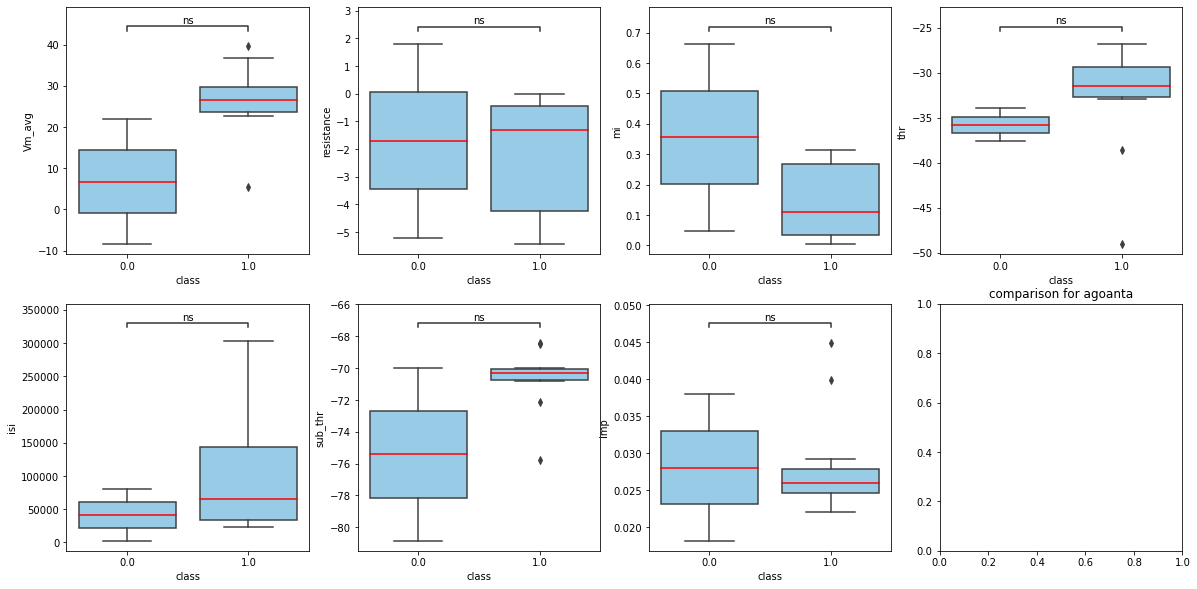

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:8.647e-02 U_stat=3.000e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:2.636e-01 U_stat=2.300e+01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:8.231e-01 U_stat=1.700e+01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitne

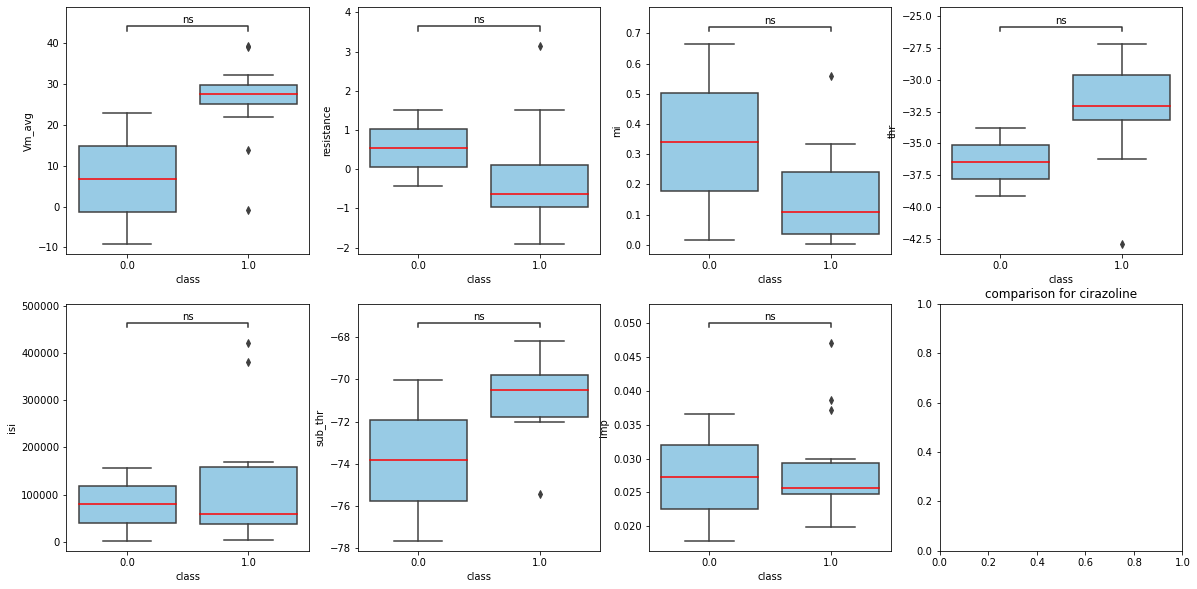

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:1.879e-03 U_stat=2.255e+02
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:5.562e-01 U_stat=4.715e+02
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:4.415e-01 U_stat=3.805e+02
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitne

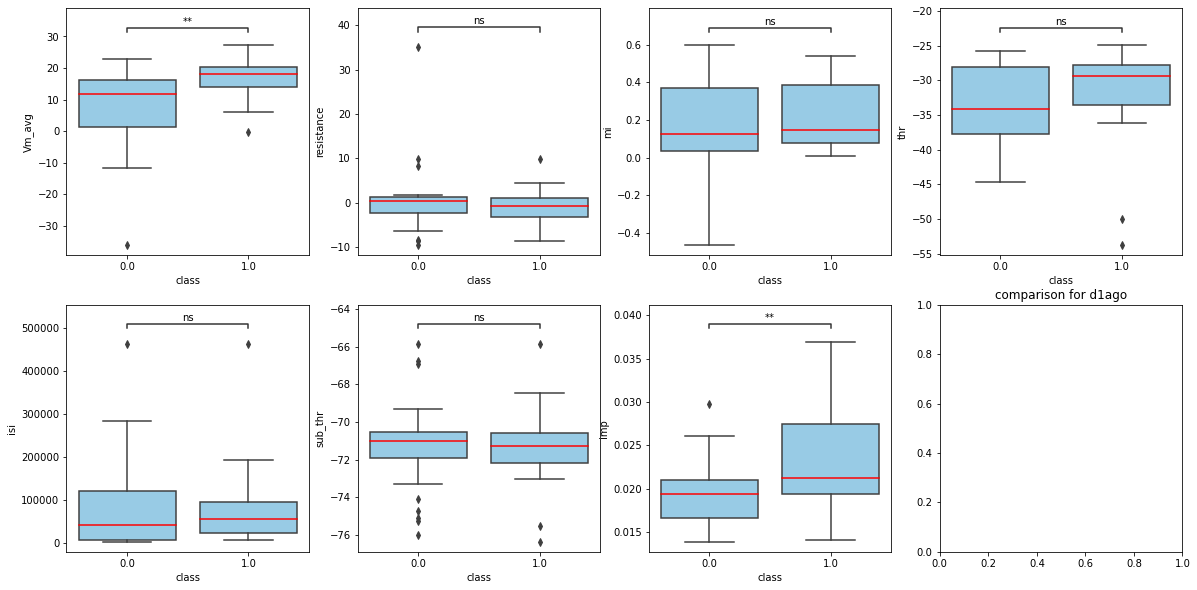

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:1.474e-03 U_stat=3.900e+01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:6.591e-01 U_stat=1.590e+02
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:4.968e-02 U_stat=2.090e+02
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitne

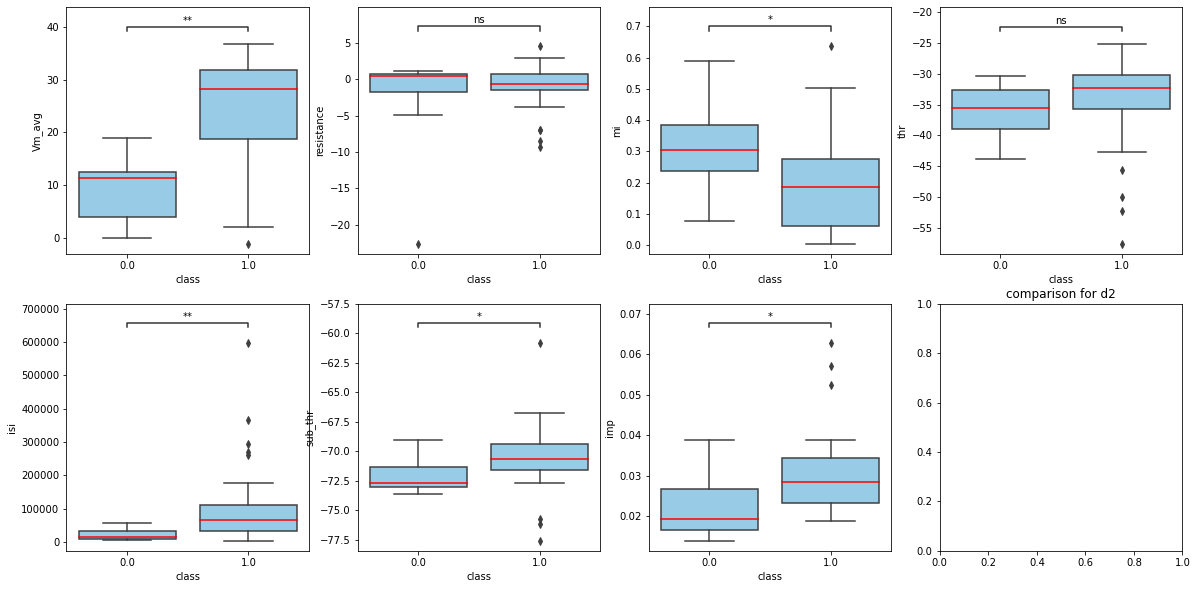

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:2.164e-01 U_stat=2.600e+01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:7.239e-01 U_stat=3.600e+01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:6.588e-01 U_stat=4.600e+01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitne

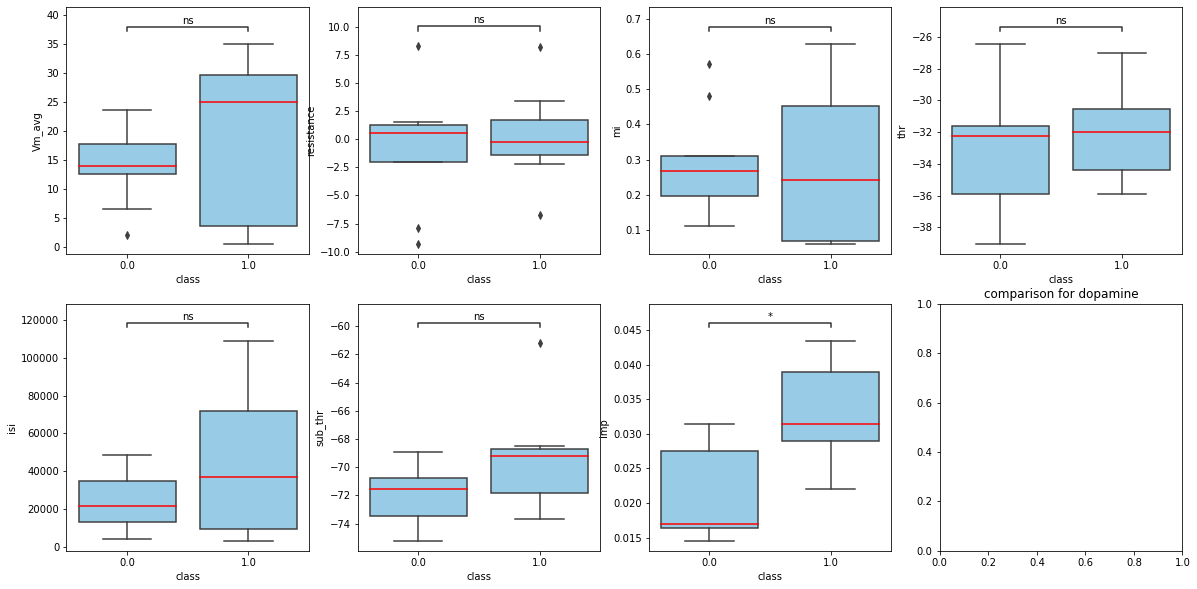

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:3.810e-02 U_stat=5.700e+01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:7.177e-01 U_stat=1.020e+02
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:3.919e-01 U_stat=1.350e+02
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitne

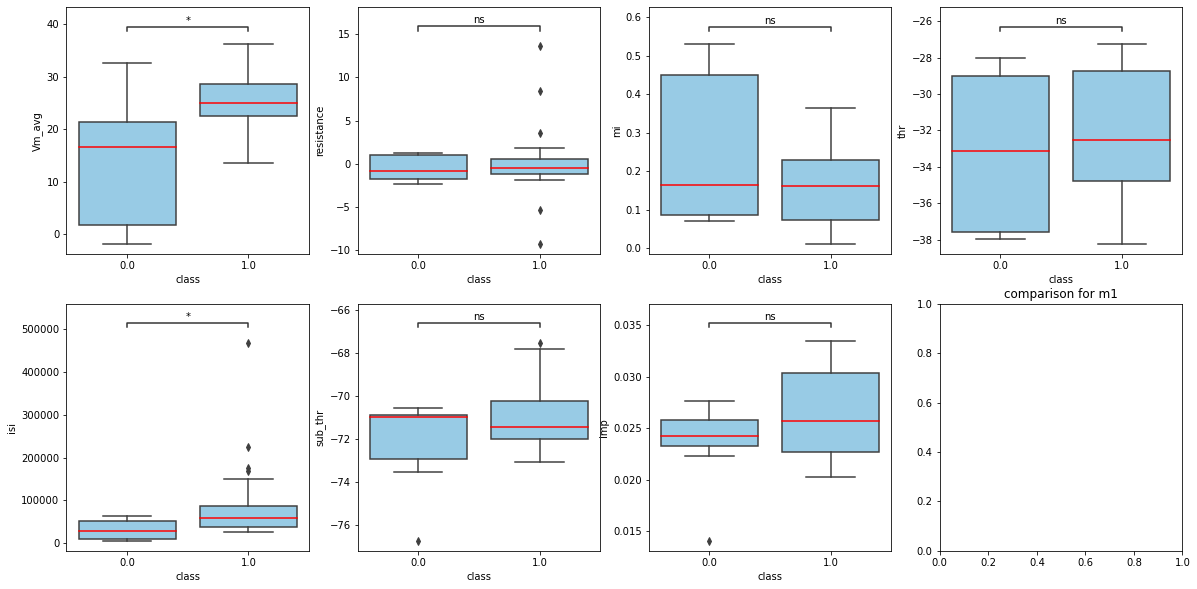

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:2.049e-01 U_stat=7.000e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:2.049e-01 U_stat=7.000e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitney-Wilcoxon test two-sided, P_val:7.998e-01 U_stat=1.700e+01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.0 vs. 1.0: Mann-Whitne

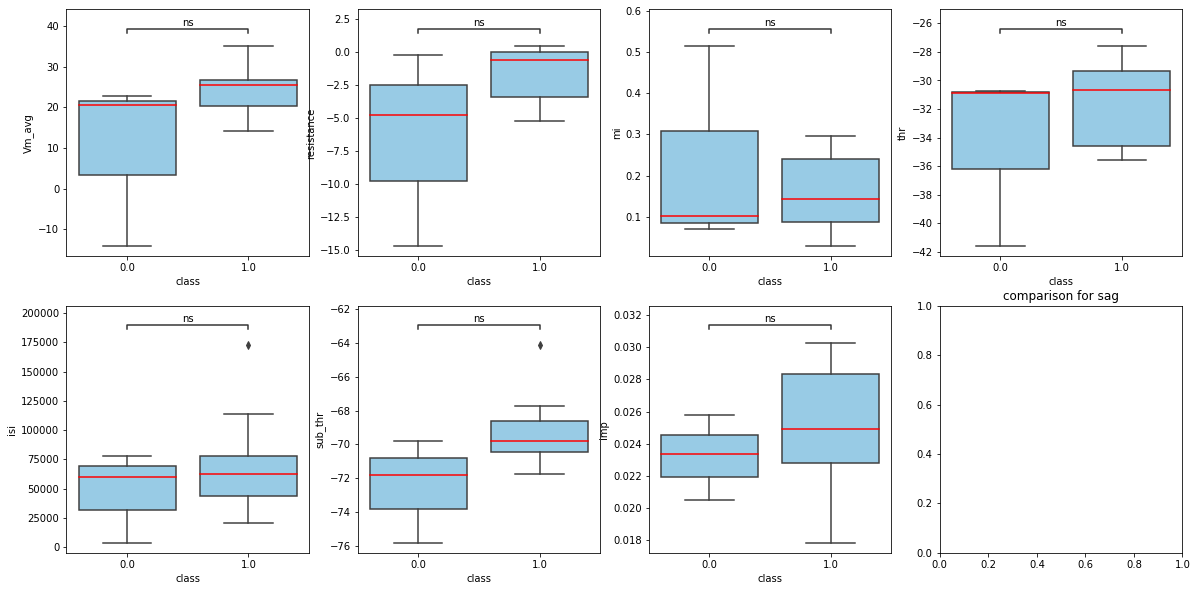

In [115]:

for cond_i in conds_exc:
    fig,ax = plt.subplots(2,4,figsize=[20,10])
    for i,val in enumerate(['Vm_avg', 'resistance','mi', 'thr', 'isi', 'sub_thr','imp']):
        if i<4:
            plot_significance_new(data = df_exc_for_sig[df_exc_for_sig.cond==cond_i],var = val,hue = 'class',ax = ax[0,i])
        else:
            plot_significance_new(data = df_exc_for_sig[df_exc_for_sig.cond==cond_i],var = val,hue = 'class',ax = ax[1,i-4])
    plt.title('comparison for '+cond_i)
    plt.show()


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs. 1.0_agoanta: t-test independent samples, P_val:3.185e-01 t=-1.000e+00
0.0_acsf vs. 0.0_agoanta: t-test independent samples, P_val:8.163e-01 t=-2.328e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs. 1.0_agoanta: t-test independent samples, P_val:3.126e-01 t=1.012e+00
0.0_acsf vs. 0.0_agoanta: t-test independent samples, P_val:8.256e-01 t=2.208e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs. 1.0_agoanta: t-test independent samples, P_val:9.946e-02 t=1.655e+00
0.0_acsf vs. 0.0_agoanta: t-test independent 

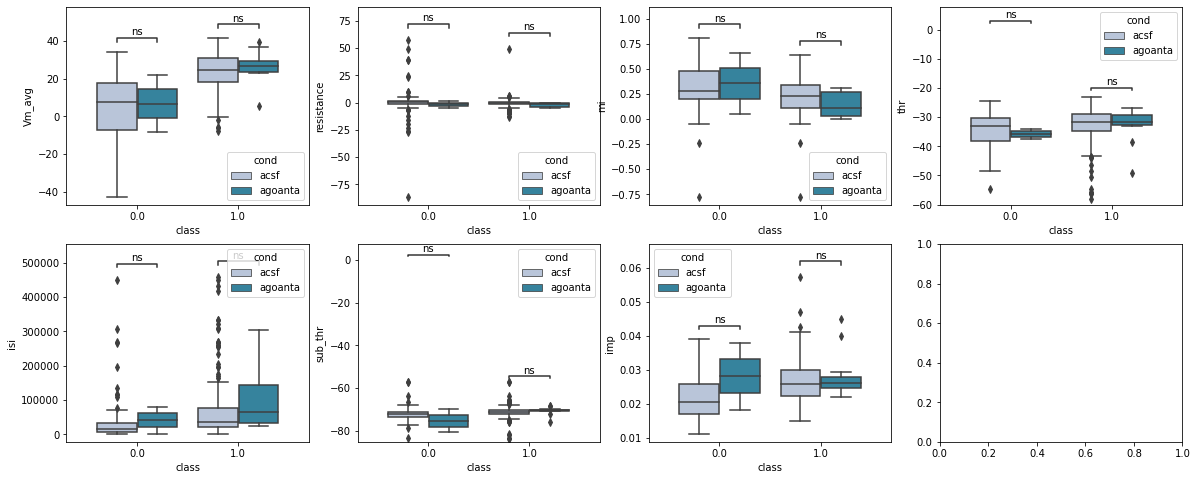

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs. 1.0_cirazoline: t-test independent samples, P_val:3.150e-01 t=-1.007e+00
0.0_acsf vs. 0.0_cirazoline: t-test independent samples, P_val:8.108e-01 t=-2.399e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs. 1.0_cirazoline: t-test independent samples, P_val:6.443e-01 t=-4.624e-01
0.0_acsf vs. 0.0_cirazoline: t-test independent samples, P_val:9.834e-01 t=-2.079e-02
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs. 1.0_cirazoline: t-test independent samples, P_val:1.492e-01 t=1.448e+00
0.0_acsf vs. 0.0_cirazoline:

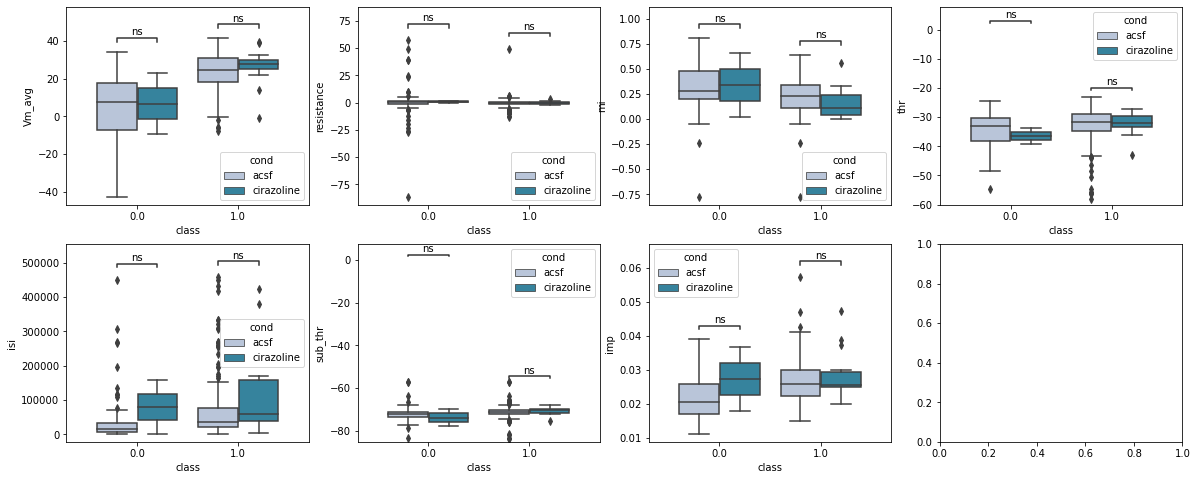

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs. 1.0_d1ago: t-test independent samples, P_val:1.576e-03 t=3.203e+00
0.0_acsf vs. 0.0_d1ago: t-test independent samples, P_val:1.951e-01 t=-1.301e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs. 1.0_d1ago: t-test independent samples, P_val:7.105e-01 t=3.717e-01
0.0_acsf vs. 0.0_d1ago: t-test independent samples, P_val:9.275e-01 t=9.108e-02
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs. 1.0_d1ago: t-test independent samples, P_val:7.463e-01 t=3.240e-01
0.0_acsf vs. 0.0_d1ago: t-test independent samples, P_va

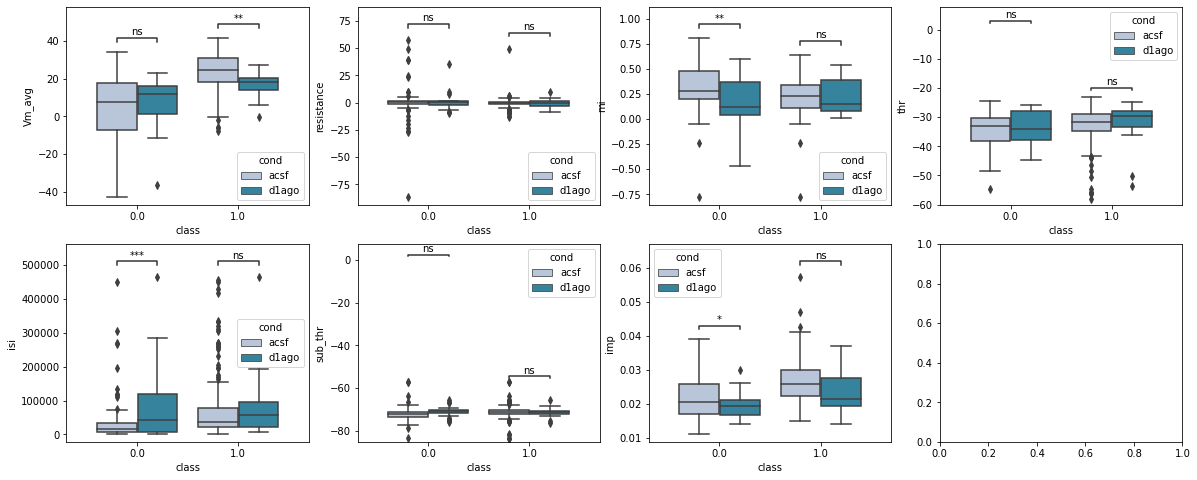

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs. 1.0_d2: t-test independent samples, P_val:6.792e-01 t=-4.141e-01
0.0_acsf vs. 0.0_d2: t-test independent samples, P_val:4.016e-01 t=-8.416e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs. 1.0_d2: t-test independent samples, P_val:7.862e-01 t=2.715e-01
0.0_acsf vs. 0.0_d2: t-test independent samples, P_val:4.656e-01 t=7.319e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs. 1.0_d2: t-test independent samples, P_val:3.657e-01 t=9.065e-01
0.0_acsf vs. 0.0_d2: t-test independent samples, P_val:9.945e-01 t=6.8

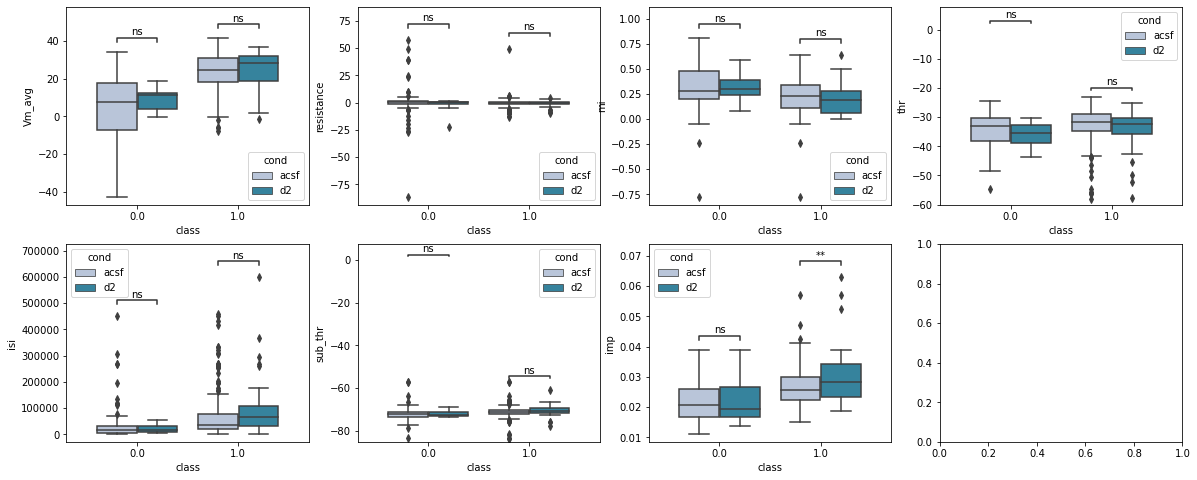

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs. 1.0_dopamine: t-test independent samples, P_val:2.706e-01 t=1.105e+00
0.0_acsf vs. 0.0_dopamine: t-test independent samples, P_val:1.272e-01 t=-1.535e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs. 1.0_dopamine: t-test independent samples, P_val:4.768e-01 t=-7.129e-01
0.0_acsf vs. 0.0_dopamine: t-test independent samples, P_val:7.921e-01 t=2.641e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs. 1.0_dopamine: t-test independent samples, P_val:3.467e-01 t=-9.432e-01
0.0_acsf vs. 0.0_dopamine: t-test indep

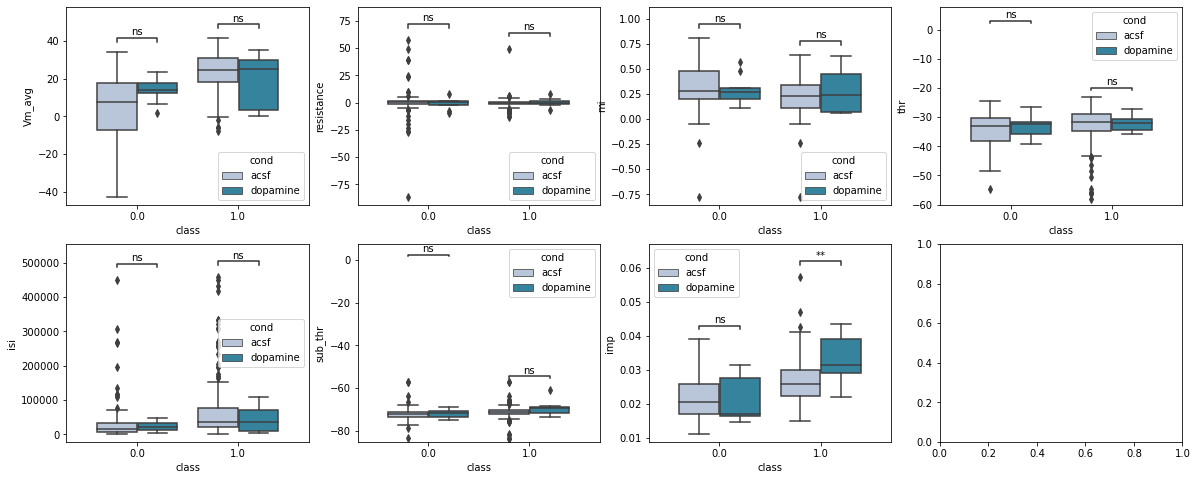

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs. 1.0_m1: t-test independent samples, P_val:3.950e-01 t=-8.524e-01
0.0_acsf vs. 0.0_m1: t-test independent samples, P_val:1.228e-01 t=-1.553e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs. 1.0_m1: t-test independent samples, P_val:3.638e-01 t=-9.102e-01
0.0_acsf vs. 0.0_m1: t-test independent samples, P_val:8.525e-01 t=1.863e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs. 1.0_m1: t-test independent samples, P_val:6.191e-02 t=1.877e+00
0.0_acsf vs. 0.0_m1: t-test independent samples, P_val:4.290e-01 t=7.

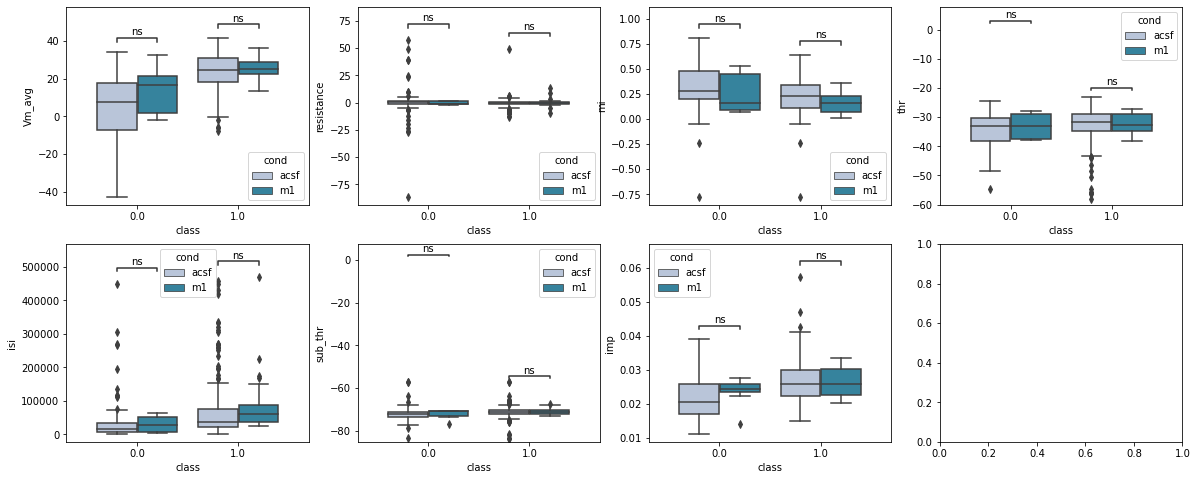

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs. 1.0_sag: t-test independent samples, P_val:6.967e-01 t=-3.903e-01
0.0_acsf vs. 0.0_sag: t-test independent samples, P_val:5.898e-01 t=-5.406e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs. 1.0_sag: t-test independent samples, P_val:5.909e-01 t=5.384e-01
0.0_acsf vs. 0.0_sag: t-test independent samples, P_val:3.670e-01 t=9.054e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs. 1.0_sag: t-test independent samples, P_val:2.447e-01 t=1.167e+00
0.0_acsf vs. 0.0_sag: t-test independent samples, P_val:5.019e-01

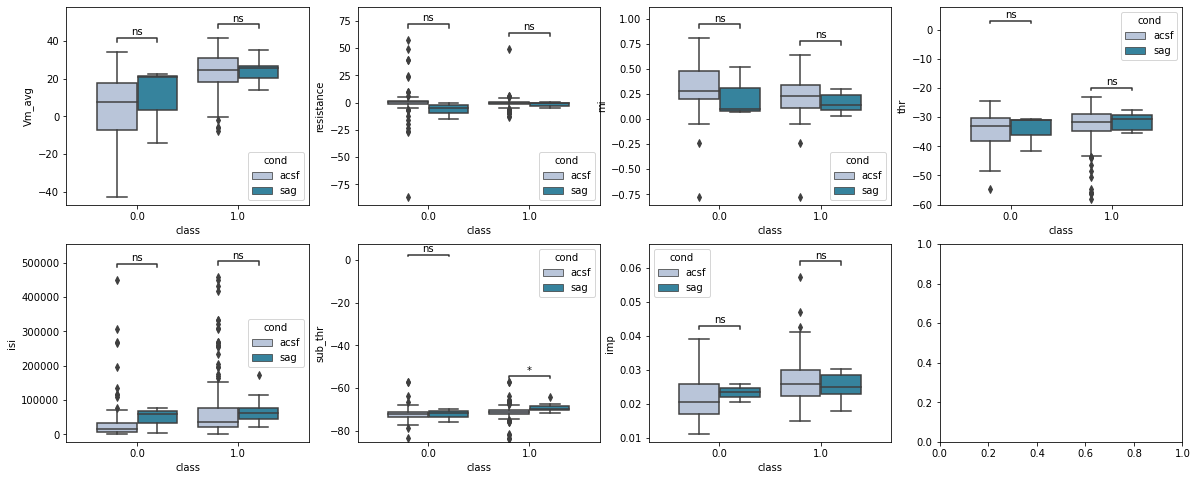

In [174]:
test_type = 't-test_ind'
for cond_ in cond_exc[1:]:
        fig,ax = plt.subplots(2,4,figsize= [20,8])
        for i, var  in enumerate(['Vm_avg', 'resistance','mi', 'thr', 'isi', 'sub_thr','imp']):
                cond = cond_
                data_temp = df_exc_for_sig[df_exc_for_sig.cond.isin(['acsf',cond])]
                if i>=4:

                        sns.boxplot(data=data_temp,
                                        x='class',
                                        y= var,
                                        hue ='cond',ax=ax[1,i-4],palette='PuBuGn')
                                        # boxprops={"facecolor": (.2, .6, .8, .5)},
                                        # medianprops={"color": "red"})                         

                        pairs = np.unique(data_temp['class'])
                        pairs = [((0.0,"acsf"),(0.0,cond)),
                                ((1.0, "acsf" ),(1.0,cond))]


                        annotator = Annotator(ax[1,i-4],pairs, data=data_temp, x='class', y=var,hue='cond')
                        annotator.configure(test=test_type, text_format='star', loc='inside')
                        annotator.apply_and_annotate()  
                if i<4:

                        sns.boxplot(data=data_temp,
                                        x='class',
                                        y= var,
                                        hue ='cond',ax=ax[0,i],palette='PuBuGn')
                                        # boxprops={"facecolor": (.2, .6, .8, .5)},
                                        # medianprops={"color": "red"})                            

                        pairs = np.unique(data_temp['class'])
                        pairs = [((0.0,"acsf"),(0.0,cond)),
                                ((1.0, "acsf" ),(1.0,cond))]


                        annotator = Annotator(ax[0,i],pairs, data=data_temp, x='class', y=var,hue='cond')
                        annotator.configure(test=test_type, text_format='star', loc='inside')
                        annotator.apply_and_annotate()                          
        plt.show()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs. 1.0_agoanta: t-test independent samples, P_val:8.785e-01 t=-1.534e-01
0.0_acsf vs. 0.0_agoanta: t-test independent samples, P_val:1.283e-01 t=1.537e+00
2.0_acsf vs. 2.0_agoanta: t-test independent samples, P_val:8.206e-01 t=-2.311e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs. 1.0_agoanta: t-test independent samples, P_val:2.196e-01 t=-1.239e+00
0.0_acsf vs. 0.0_agoanta: t-test independent samples, P_val:5.152e-01 t=-6.537e-01
2.0_acsf vs. 2.0_agoanta: t-test independent samples, P_val:1.021e-01 t=-1.749e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 <

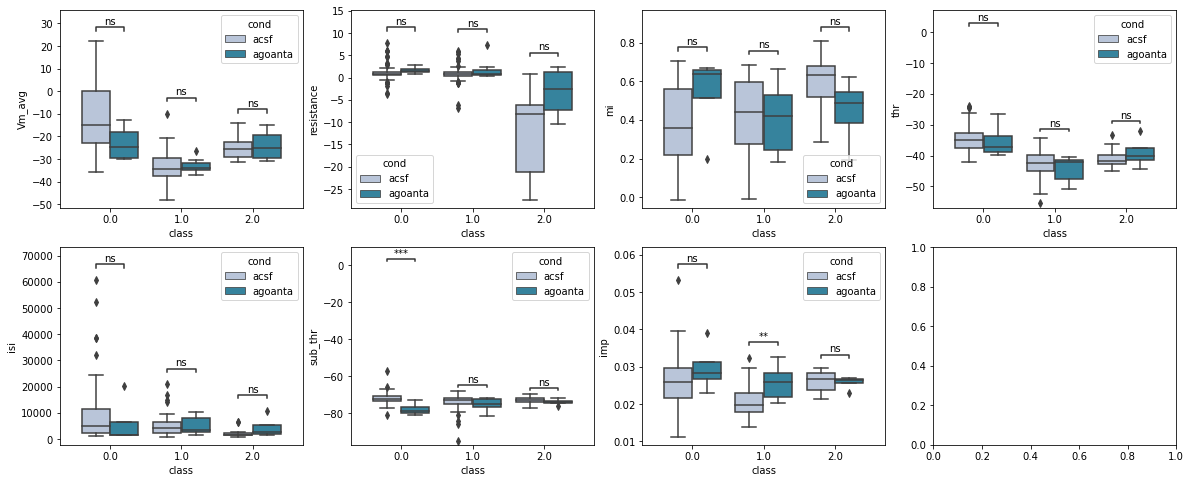

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs. 1.0_cirazoline: t-test independent samples, P_val:9.865e-01 t=1.700e-02
0.0_acsf vs. 0.0_cirazoline: t-test independent samples, P_val:2.883e-01 t=1.069e+00
2.0_acsf vs. 2.0_cirazoline: t-test independent samples, P_val:5.187e-01 t=-6.634e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs. 1.0_cirazoline: t-test independent samples, P_val:9.316e-02 t=-1.702e+00
0.0_acsf vs. 0.0_cirazoline: t-test independent samples, P_val:8.369e-03 t=-2.703e+00
2.0_acsf vs. 2.0_cirazoline: t-test independent samples, P_val:1.574e-01 t=-1.500e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
   

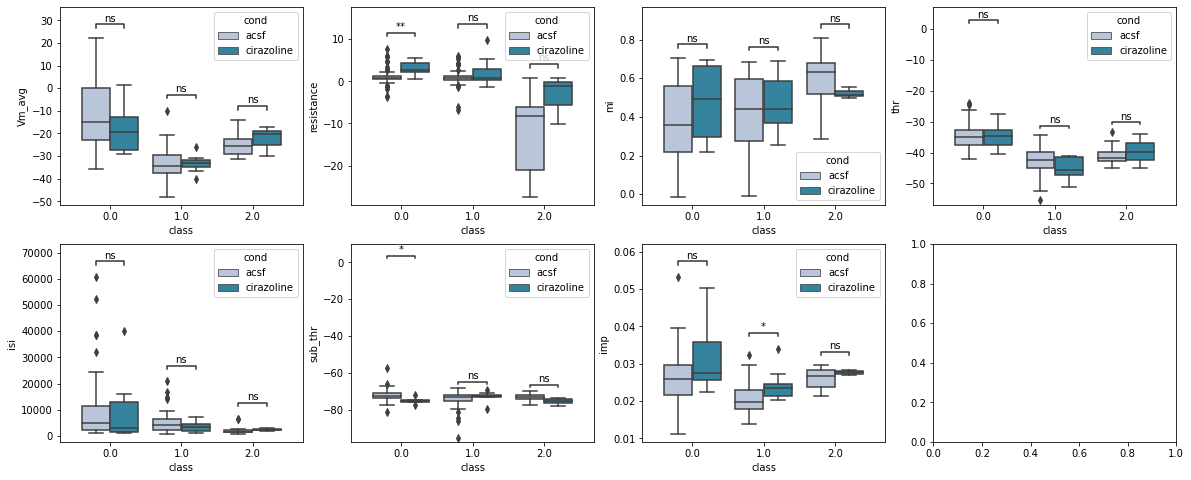

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs. 1.0_d1ago: t-test independent samples, P_val:6.697e-01 t=-4.281e-01
0.0_acsf vs. 0.0_d1ago: t-test independent samples, P_val:9.577e-02 t=1.685e+00
2.0_acsf vs. 2.0_d1ago: t-test independent samples, P_val:9.912e-01 t=1.126e-02
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs. 1.0_d1ago: t-test independent samples, P_val:6.606e-01 t=4.407e-01
0.0_acsf vs. 0.0_d1ago: t-test independent samples, P_val:6.003e-01 t=5.261e-01
2.0_acsf vs. 2.0_d1ago: t-test independent samples, P_val:8.947e-02 t=-1.847e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03


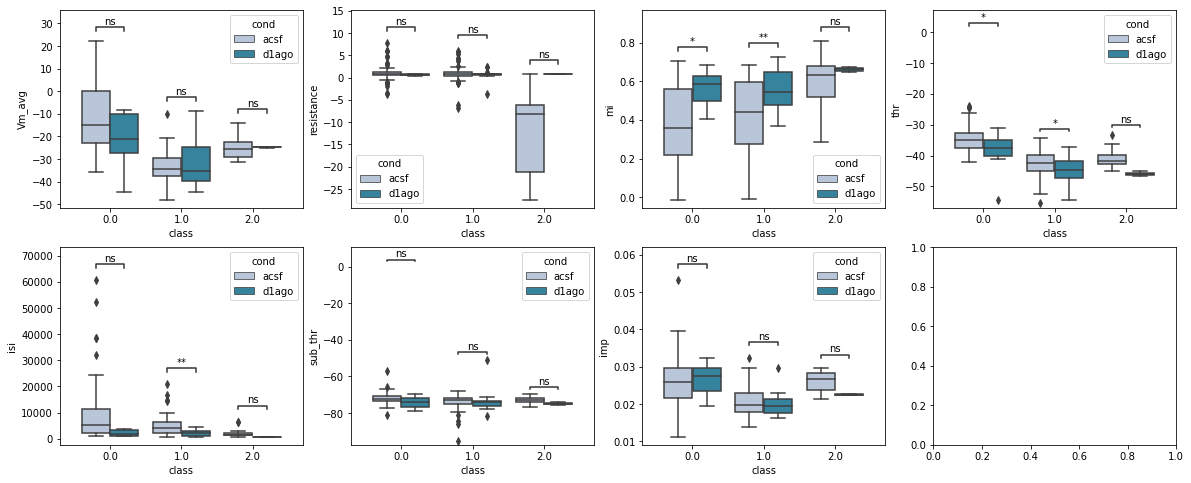

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs. 1.0_d2: t-test independent samples, P_val:3.451e-01 t=9.508e-01
0.0_acsf vs. 0.0_d2: t-test independent samples, P_val:3.941e-01 t=-8.565e-01
2.0_acsf vs. 2.0_d2: t-test independent samples, P_val:nan t=nan
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs. 1.0_d2: t-test independent samples, P_val:2.374e-02 t=2.314e+00
0.0_acsf vs. 0.0_d2: t-test independent samples, P_val:7.046e-01 t=-3.804e-01
2.0_acsf vs. 2.0_d2: t-test independent samples, P_val:nan t=nan
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs. 1.0_

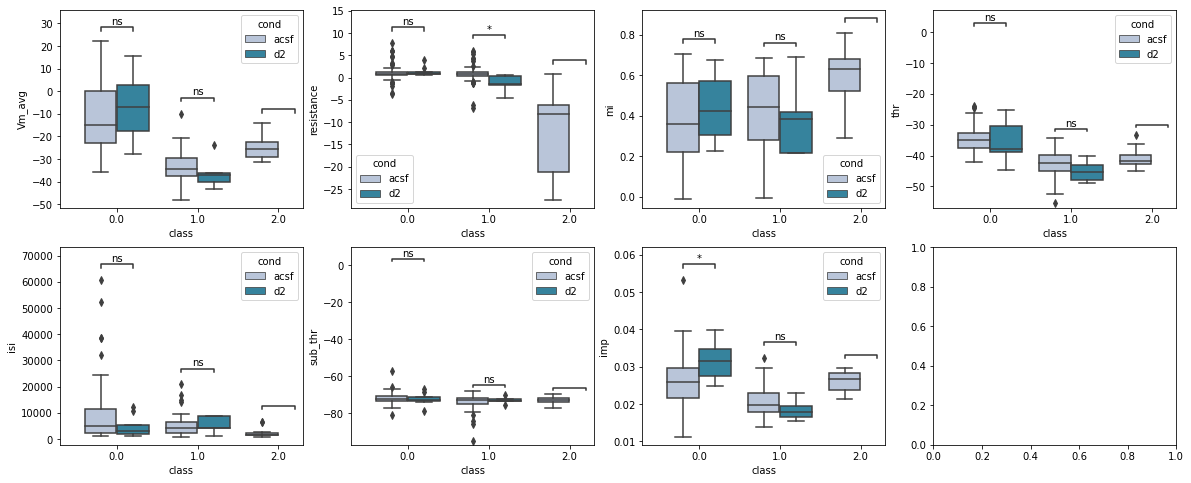

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs. 1.0_dopamine: t-test independent samples, P_val:4.849e-01 t=7.019e-01
0.0_acsf vs. 0.0_dopamine: t-test independent samples, P_val:5.823e-01 t=5.523e-01
2.0_acsf vs. 2.0_dopamine: t-test independent samples, P_val:nan t=nan


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs. 1.0_dopamine: t-test independent samples, P_val:4.758e-01 t=7.166e-01
0.0_acsf vs. 0.0_dopamine: t-test independent samples, P_val:8.563e-01 t=1.817e-01
2.0_acsf vs. 2.0_dopamine: t-test independent samples, P_val:nan t=nan


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs. 1.0_dopamine: t-test independent samples, P_val:5.415e-01 t=6.133e-01
0.0_acsf vs. 0.0_dopamine: t-test independent samples, P_val:9.703e-01 t=-3.740e-02


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


2.0_acsf vs. 2.0_dopamine: t-test independent samples, P_val:nan t=nan
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs. 1.0_dopamine: t-test independent samples, P_val:4.253e-01 t=8.015e-01
0.0_acsf vs. 0.0_dopamine: t-test independent samples, P_val:5.322e-01 t=6.275e-01
2.0_acsf vs. 2.0_dopamine: t-test independent samples, P_val:nan t=nan


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs. 1.0_dopamine: t-test independent samples, P_val:8.049e-01 t=2.479e-01
0.0_acsf vs. 0.0_dopamine: t-test independent samples, P_val:9.933e-01 t=8.392e-03
2.0_acsf vs. 2.0_dopamine: t-test independent samples, P_val:nan t=nan


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs. 1.0_dopamine: t-test independent samples, P_val:1.053e-01 t=-1.639e+00
0.0_acsf vs. 0.0_dopamine: t-test independent samples, P_val:8.687e-01 t=1.658e-01
2.0_acsf vs. 2.0_dopamine: t-test independent samples, P_val:nan t=nan


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
c:\Users\Nishant Joshi\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs. 1.0_dopamine: t-test independent samples, P_val:9.683e-01 t=3.991e-02
0.0_acsf vs. 0.0_dopamine: t-test independent samples, P_val:1.851e-02 t=-2.406e+00
2.0_acsf vs. 2.0_dopamine: t-test independent samples, P_val:nan t=nan


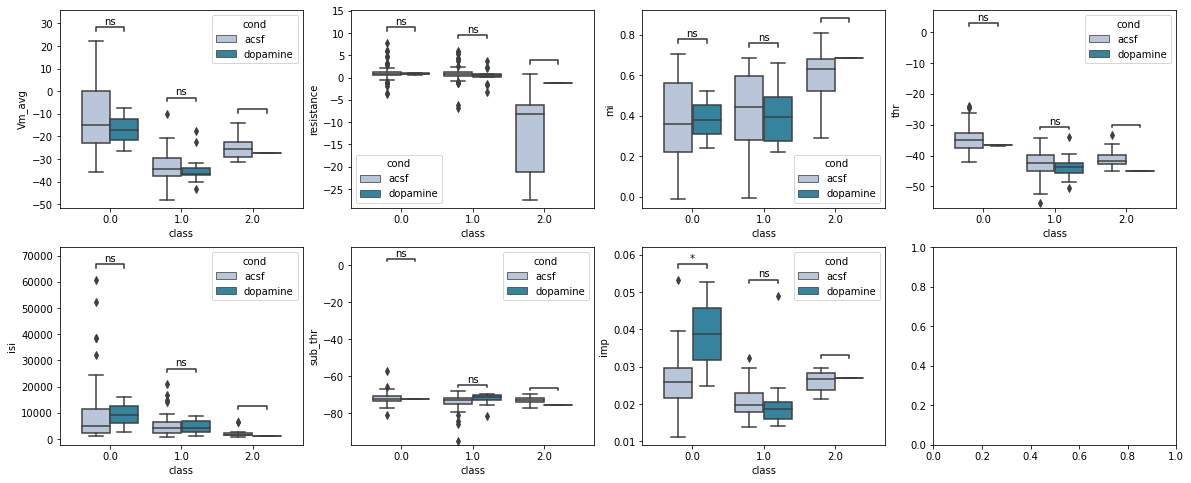

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs. 1.0_m1: t-test independent samples, P_val:1.154e-04 t=4.067e+00
0.0_acsf vs. 0.0_m1: t-test independent samples, P_val:2.378e-01 t=1.188e+00
2.0_acsf vs. 2.0_m1: t-test independent samples, P_val:6.697e-01 t=4.373e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs. 1.0_m1: t-test independent samples, P_val:9.125e-01 t=-1.102e-01
0.0_acsf vs. 0.0_m1: t-test independent samples, P_val:5.964e-01 t=-5.314e-01
2.0_acsf vs. 2.0_m1: t-test independent samples, P_val:2.418e-02 t=-2.578e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.

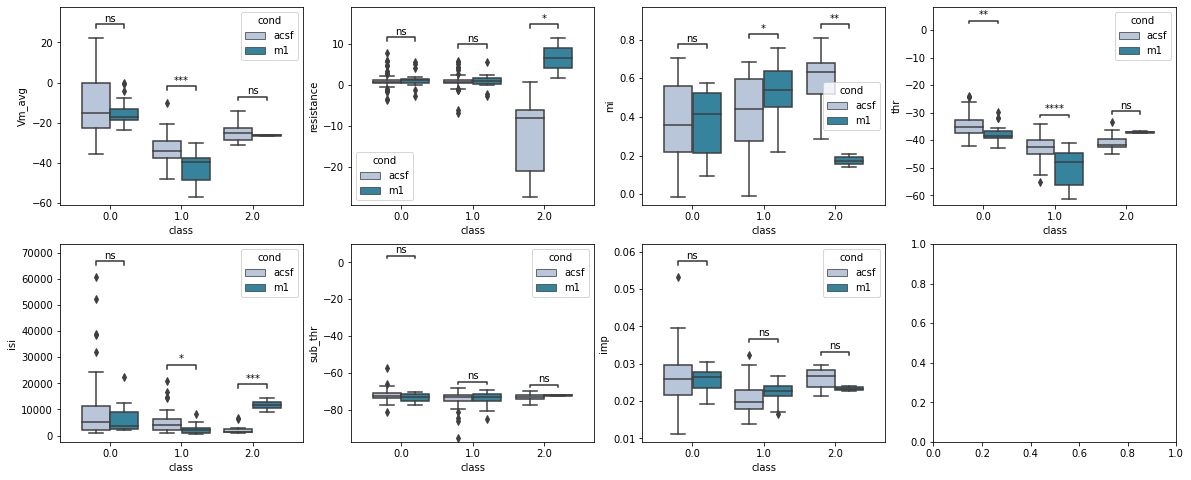

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs. 1.0_sag: t-test independent samples, P_val:9.362e-01 t=-8.041e-02
0.0_acsf vs. 0.0_sag: t-test independent samples, P_val:1.014e-01 t=1.657e+00
2.0_acsf vs. 2.0_sag: t-test independent samples, P_val:nan t=nan
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs. 1.0_sag: t-test independent samples, P_val:3.302e-01 t=9.808e-01
0.0_acsf vs. 0.0_sag: t-test independent samples, P_val:3.277e-01 t=9.849e-01
2.0_acsf vs. 2.0_sag: t-test independent samples, P_val:nan t=nan
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1.0_acsf vs.

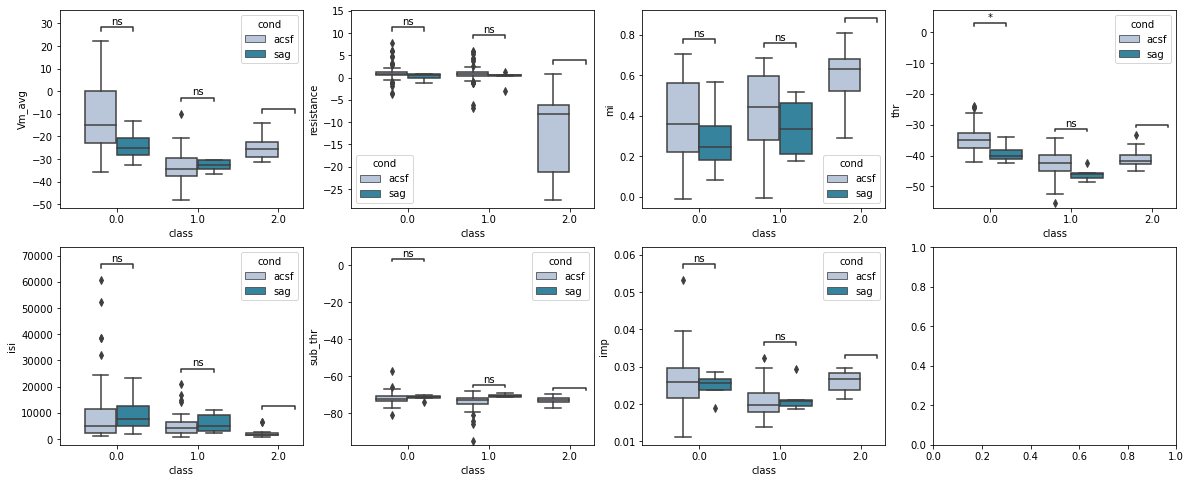

In [175]:
test_type = 't-test_ind'
for cond_ in cond_inh[1:]:
        fig,ax = plt.subplots(2,4,figsize= [20,8])
        for i, var  in enumerate(['Vm_avg', 'resistance','mi', 'thr', 'isi', 'sub_thr','imp']):
                cond = cond_
                data_temp = df_inh_for_sig[df_inh_for_sig.cond.isin(['acsf',cond])]
                if i>=4:

                        sns.boxplot(data=data_temp,
                                        x='class',
                                        y= var,
                                        hue ='cond',ax=ax[1,i-4],palette='PuBuGn')
                                        # boxprops={"facecolor": (.2, .6, .8, .5)},
                                        # medianprops={"color": "red"})                         

                        pairs = np.unique(data_temp['class'])
                        pairs = [((0.0,"acsf"),(0.0,cond)),
                                ((1.0, "acsf" ),(1.0,cond)),
                                ((2.0, "acsf" ),(2.0,cond))]


                        annotator = Annotator(ax[1,i-4],pairs, data=data_temp, x='class', y=var,hue='cond')
                        annotator.configure(test=test_type, text_format='star', loc='inside')
                        annotator.apply_and_annotate()  
                if i<4:

                        sns.boxplot(data=data_temp,
                                        x='class',
                                        y= var,
                                        hue ='cond',ax=ax[0,i],palette='PuBuGn')
                                        # boxprops={"facecolor": (.2, .6, .8, .5)},
                                        # medianprops={"color": "red"})                            

                        pairs = np.unique(data_temp['class'])
                        pairs = [((0.0,"acsf"),(0.0,cond)),
                                ((1.0, "acsf" ),(1.0,cond)),
                                ((2.0, "acsf" ),(2.0,cond))]

                        annotator = Annotator(ax[0,i],pairs, data=data_temp, x='class', y=var,hue='cond')
                        annotator.configure(test=test_type, text_format='star', loc='inside')
                        annotator.apply_and_annotate()                          
        plt.show()